In [123]:
import json
import os
import numpy as np
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
from docx import Document
from docx.shared import Pt
import pickle
import os
from tqdm import tqdm
import time
from langdetect import detect
import matplotlib.pyplot as plt
import collections
from IPython.display import display

import spacy.cli
from spacy.language import Language
import math

from IPython.display import display
import nltk

from transformers import BertTokenizer
import seaborn as sns
from tabulate import tabulate
import prettytable
from prettytable import PrettyTable
from textwrap import fill
from deepdiff import DeepDiff
from tqdm import tqdm
from itertools import chain
import random
from collections import Counter

In [124]:
def get_mislassified_and_correct_predictions(test, pred):
    
    """
    Cerco le differenze fra le predizioni e le labels originali, facendo una DeepDiff fra il dizionario delle 
    predizioni e il dizionario delle label vere. Ecco quello che si ottiene
    
    Esempio:
    prova test:  {345: 1, 123: 0}
    prova pred:  {345: 1, 123: 1}

    diff_labels:  {'root[123]': {'new_value': 1, 'old_value': 0}}
    """
    
    # ottengo gli eventi classificati in modo errato
    misclassified_events = DeepDiff(test, pred)['values_changed']
    
    # prendo le chiavi degli eventi classificati in modo errato
    keys_misclassified_events = set(int(k.replace('root[', '').replace(']', '')) for k in misclassified_events)
    
    # e faccio la differenza fra tutti gli eventi classificati e gli eventi classificati male, 
    # perchè voglio ottenere gli eventi classificati correttamente 
    set_classified_events = set(list(pred.keys()))
    
    keys_correct_events = set_classified_events - keys_misclassified_events
    
    diz_correct_events = {}
    
    for k in keys_correct_events:
        diz_correct_events[k] = pred[k]
        
    misclassified_events = {int(k.replace('root[', '').replace(']', '')):v for k,v in misclassified_events.items()}
        
    return misclassified_events, diz_correct_events, keys_misclassified_events, keys_correct_events

In [125]:
def get_diff_classifications(lista_df_test, lista_dist, lista_diz_pred, lista_clf_epoch):
    
    diz_global = {}

    for df_test, dist, diz_pred in tqdm(zip(lista_df_test, lista_dist, lista_diz_pred)):
        
        diz_global[dist] = {}

        test = df_test.set_index('Id')[['Class']].astype('int64').to_dict(orient='dict')['Class']
    
        for clf_epoch in lista_clf_epoch:
            
            diz_global[dist][clf_epoch] = {}

            pred = {k:int(val) for k,val in diz_pred['{}'.format(dist)][clf_epoch]['ids_preds'].items()}
        
            misclassified_events, diz_correct_events, \
                keys_misclassified_events, keys_correct_events = get_mislassified_and_correct_predictions(test, pred)
            
            diz_global[dist][clf_epoch]['misclassified_events'] = misclassified_events
            diz_global[dist][clf_epoch]['diz_correct_events'] = diz_correct_events
            diz_global[dist][clf_epoch]['keys_misclassified_events'] = keys_misclassified_events
            diz_global[dist][clf_epoch]['keys_correct_events'] = keys_correct_events
            
    return diz_global

In [126]:
def save_dataframe(file_name, dataframe_to_save):
    
    try:
        dataframe_to_save.to_csv(path_salvataggio+file_name+".csv", index = False, sep = "\t", encoding='utf-8')
        print("File salvato correttamente")
        
    except:
        print("Errore nel salvataggio")
    
    return 

**Vogliamo trovare eventi classificati correttamente o meno sia dai singoli classificatori, sia da entrambi i classificatori, in modo da mostrare le rispettive probabilità di classificazione e capire la sicurezza del modello nel predire un certo risultato.**

In [127]:
path_pickle = "../pickle/"

In [128]:
path_dataset = "../dataset/train_test/"

In [129]:
path_salvataggio = "../dataset/confronti_classificazione_eventi/"

In [130]:
path_diz_res = "../eventi_classificati_bene_male/"

In [131]:
path_images = "../plots/"
path_images_tit_ridotti = "../plots_titoli_ridotti/"

# Dataset di test originali

In [132]:
df_dist_5_test = pd.read_csv(path_dataset + "df_dist_5_with_ids_ridotto_test.csv", sep="\t")
df_dist_10_test = pd.read_csv(path_dataset + "df_dist_10_with_ids_ridotto_test.csv", sep="\t")
df_dist_20_test = pd.read_csv(path_dataset + "df_dist_20_with_ids_ridotto_test.csv", sep="\t")
df_dist_30_test = pd.read_csv(path_dataset + "df_dist_30_with_ids_ridotto_test.csv", sep="\t")
df_random_speech_test = pd.read_csv(path_dataset + "df_random_speech_with_ids_ridotto_test.csv", sep="\t")

In [133]:
df_dist_5_test

,Id,Sentence_1,Sentence_2,Class
0,3511,È questo «in nome del popolo italiano»?,"Signor Presidente, ho chiesto di intervenire a fine seduta perché non mi do pace: c'è un'altra sentenza scandalosa, signor Presidente, sul caso di Stefano Cucchi.",1
1,443194,"Non guardiamo a soluzioni come l'erezione di muri che certamente non servono ad affrontare il problema, semmai ad aggravarlo nel momento in cui ognuno si chiude in una condizione di isolamento e di distacco rispetto ad un problema, rendendolo così ancora più grave perché poi ricade sui Paesi di prima accoglienza come l'Italia, la Grecia o la Turchia che si devono trovare spesso da soli ad affrontarlo.","Tutto ciò deve necessariamente avvenire attraverso una serie di accordi, anche bilaterali - come in questi giorni è avvenuto tra l'Egitto, la Grecia e Cipro - per affrontare i problemi riguardanti il transito e l'immigrazione, che purtroppo oggi assumono numeri da tragedia epocale.",1
2,438394,"La popolazione carceraria è scesa a 52.164 e sono cresciute, invece, a 39.274 le persone in esecuzione di pena esterna.",Sei anni fa i detenuti erano 67.971 e 21.494 le persone in esecuzione penale esterna.,0
3,313751,"Mi fermo perché non voglio offendere nessuno, proprio per dire che sono gli elementi basilari del diritto penale.",Ci ridono dietro!,1
4,488165,"La prima riunione europea dei Ministri della salute sul coronavirus si è tenuta, su richiesta formale dell'Italia, da me firmata, già a fine gennaio.","Siamo un grande Paese, che ha svolto un lavoro serio, che ci viene costantemente riconosciuto dall'Organizzazione mondiale della sanità, con cui c'è una relazione continua e proficua.",1
...,...,...,...,...
2395,35231,"Non è un caso che il Governo e la maggioranza che lo sostiene non siano riusciti a difendere questo testo dalle aspre polemiche che si sono accese nel corso dell'esame alla Camera, e che hanno portato l'altro ramo del Parlamento a licenziare un testo per nulla condivisibile, neanche da settori importanti della maggioranza, fatto di usuali divieti, obblighi, ostacoli e sospetti nei confronti dell'unico soggetto in grado di creare lavoro, cioè l'impresa, che impiega persone, cittadini, uomini e donne nei processi produttivi.",Ma neanche il testo di mediazione che la Commissione ha approvato ieri a noi appare condivisibile.,0
2396,300044,"Anzi, svolse sempre con passione e consapevolezza un ruolo da dirigente saggio, fermo, saldo, sereno e combattivo, sempre disponibile all'ascolto, al dialogo e al confronto.","Con lui scompare una figura importante della sinistra, che tanto ha dato alla politica della sua città e che ha lavorato con competenza, serietà e profondità, qui nel ruolo di senatore in Commissione istruzione, poi in Commissione lavoro e in Commissione di vigilanza RAI; una vita dedicata all'impegno pubblico; una vita densa di passione, coerenza e lealtà.",0
2397,74207,È chiaro che una catastrofe delle dimensioni di un terremoto non può mai esaurirsi in un solo provvedimento normativo.,"Cito, prima di invitare l'Assemblea all'approvazione, due questioni che appaiono a prima vista minori, ma che ritengo siano state già rappresentate negli ordini del giorno e che meritano l'attenzione dell'Assemblea.",1
2398,390608,"Se doveva cadere così in basso, era più dignitoso abolirlo.","Un'Assemblea tanto grande quanto debole, i cui membri devono tutto alla nomina dei capipartito oppure all'aumento dei seggi connessi con l'elezione del Premier.",1


In [134]:
for id_ev in diz_intersections_svm['df_dist_5']['other_events_correct']:
    display(df_dist_5_test[df_dist_5_test['Id'] == id_ev])

NameError: name 'diz_intersections_svm' is not defined

In [ ]:
df_dist_5_test[df_dist_5_test['Id'] == 173444]

In [ ]:
for clf in lista_clf:
    print(diz_dist_5_svm['df_dist_5'][clf]['ids_preds'][173444])

In [ ]:
diz_intersections_svm['df_dist_5']['other_events_correct']

# Risultati classificazione SVM

In [136]:
dist_5_svm = open(path_pickle + "/" + "diz_classifiers_bert_svm_df_dist_5.pickle", "rb")
dist_10_svm = open(path_pickle + "/" + "diz_classifiers_bert_svm_df_dist_10.pickle", "rb")
dist_20_svm = open(path_pickle + "/" + "diz_classifiers_bert_svm_df_dist_20.pickle", "rb")
dist_30_svm = open(path_pickle + "/" + "diz_classifiers_bert_svm_df_dist_30.pickle", "rb")
dist_random_speech_svm = open(path_pickle + "/" + "diz_classifiers_bert_svm_df_random_speech.pickle", "rb")

diz_dist_5_svm = pickle.load(dist_5_svm)
diz_dist_10_svm = pickle.load(dist_10_svm)
diz_dist_20_svm = pickle.load(dist_20_svm)
diz_dist_30_svm = pickle.load(dist_30_svm)
diz_random_speech_svm = pickle.load(dist_random_speech_svm)

# Risultati classificazione BERT fine-tunato

In [137]:
dist_5_bf = open(path_pickle + "/" + "df_dist_5_diz_bert_finetuning.pickle", "rb")
dist_10_bf = open(path_pickle + "/" + "df_dist_10_diz_bert_finetuning.pickle", "rb")
dist_20_bf = open(path_pickle + "/" + "df_dist_20_diz_bert_finetuning.pickle", "rb")
dist_30_bf = open(path_pickle + "/" + "df_dist_30_diz_bert_finetuning.pickle", "rb")
random_speech_bf = open(path_pickle + "/" + "df_random_speech_diz_bert_finetuning.pickle", "rb")

diz_dist_5_bf = pickle.load(dist_5_bf)
diz_dist_10_bf = pickle.load(dist_10_bf)
diz_dist_20_bf = pickle.load(dist_20_bf)
diz_dist_30_bf = pickle.load(dist_30_bf)
diz_random_speech_bf = pickle.load(random_speech_bf)

In [138]:
risorsa = "ParlaMint"

In [139]:
lista_clf = ["clf_{}".format(i) for i in range(1,13)]
print(lista_clf)
print()

lista_epoche = ['Epoch{}'.format(i) for i in range (0,5)]
print(lista_epoche)
print()

lista_dist = ['df_dist_5', 'df_dist_10', 'df_dist_20', 'df_dist_30', 'df_random_speech']
print(lista_dist)

lista_df_test = [df_dist_5_test, df_dist_10_test, df_dist_20_test, df_dist_30_test, df_random_speech_test]

lista_diz_pred_svm = [diz_dist_5_svm, diz_dist_10_svm, diz_dist_20_svm, diz_dist_30_svm, diz_random_speech_svm]

lista_diz_pred_bert_finetunato = [diz_dist_5_bf, diz_dist_10_bf, diz_dist_20_bf, diz_dist_30_bf, diz_random_speech_bf]

['clf_1', 'clf_2', 'clf_3', 'clf_4', 'clf_5', 'clf_6', 'clf_7', 'clf_8', 'clf_9', 'clf_10', 'clf_11', 'clf_12']

['Epoch0', 'Epoch1', 'Epoch2', 'Epoch3', 'Epoch4']

['df_dist_5', 'df_dist_10', 'df_dist_20', 'df_dist_30', 'df_random_speech']


### Prendiamo, per ogni distanza, per ogni classificatore o epoca, tutti gli eventi classificati correttamente o in modo errato

In [140]:
diz_global_svm = get_diff_classifications(lista_df_test, lista_dist, lista_diz_pred_svm, lista_clf)

5it [00:05,  1.06s/it]


In [141]:
diz_global_bert = get_diff_classifications(lista_df_test, lista_dist, lista_diz_pred_bert_finetunato, lista_epoche)

5it [00:02,  2.26it/s]


In [142]:
diz_global_bert['df_dist_5'].keys()

dict_keys(['Epoch0', 'Epoch1', 'Epoch2', 'Epoch3', 'Epoch4'])

In [143]:
for dist in diz_global_svm:
    print("{}: {} clf".format(dist, len(diz_global_svm[dist])))

df_dist_5: 12 clf
df_dist_10: 12 clf
df_dist_20: 12 clf
df_dist_30: 12 clf
df_random_speech: 12 clf


In [144]:
for dist in diz_global_bert:
    print("{}: {} epochs".format(dist, len(diz_global_bert[dist])))

df_dist_5: 5 epochs
df_dist_10: 5 epochs
df_dist_20: 5 epochs
df_dist_30: 5 epochs
df_random_speech: 5 epochs


In [145]:
diz_global_svm['df_dist_5']['clf_1'].keys()

dict_keys(['misclassified_events', 'diz_correct_events', 'keys_misclassified_events', 'keys_correct_events'])

In [146]:
diz_global_svm['df_dist_5']['clf_1']['diz_correct_events']

{223234: 1,
 315394: 1,
 430083: 0,
 897029: 0,
 718850: 0,
 22534: 0,
 804872: 0,
 643080: 0,
 813066: 0,
 743431: 1,
 673804: 0,
 694281: 1,
 12302: 0,
 464910: 0,
 217107: 1,
 507927: 0,
 843799: 1,
 880674: 1,
 466979: 0,
 583716: 0,
 81957: 0,
 671787: 0,
 886827: 0,
 796717: 1,
 354347: 0,
 639023: 0,
 419887: 0,
 460848: 0,
 886835: 0,
 446521: 0,
 806969: 0,
 823355: 1,
 405561: 0,
 127037: 0,
 684090: 1,
 344127: 0,
 24640: 0,
 819265: 1,
 256063: 1,
 79931: 0,
 309311: 0,
 368710: 0,
 219207: 0,
 41032: 0,
 575560: 0,
 194636: 1,
 192591: 1,
 823378: 1,
 325714: 0,
 542804: 1,
 122966: 0,
 444512: 1,
 170080: 0,
 569442: 0,
 311395: 1,
 235621: 1,
 290918: 0,
 845929: 1,
 753770: 0,
 127083: 0,
 71787: 1,
 2157: 1,
 675949: 1,
 268399: 1,
 407665: 0,
 454770: 1,
 311411: 1,
 34931: 0,
 155765: 0,
 718961: 0,
 714872: 1,
 438394: 0,
 516219: 0,
 868475: 1,
 532605: 0,
 112762: 0,
 219259: 1,
 692352: 1,
 129148: 1,
 473218: 0,
 886916: 0,
 311431: 0,
 360584: 0,
 698503: 0,
 2

In [147]:
len(diz_global_svm['df_dist_5']['clf_1']['diz_correct_events'])

1191

In [148]:
len(diz_global_svm['df_dist_5']['clf_1']['misclassified_events'])

1209

In [149]:
len(diz_global_svm['df_dist_30']['clf_2']['diz_correct_events'])

1255

In [150]:
len(diz_global_svm['df_dist_30']['clf_2']['misclassified_events'])

1145

In [151]:
diz_global_svm['df_dist_5']['clf_1']['misclassified_events']

{443194: {'new_value': 0, 'old_value': 1},
 313751: {'new_value': 0, 'old_value': 1},
 488165: {'new_value': 0, 'old_value': 1},
 830293: {'new_value': 0, 'old_value': 1},
 853371: {'new_value': 0, 'old_value': 1},
 272009: {'new_value': 0, 'old_value': 1},
 259644: {'new_value': 0, 'old_value': 1},
 24424: {'new_value': 1, 'old_value': 0},
 8579: {'new_value': 1, 'old_value': 0},
 179057: {'new_value': 1, 'old_value': 0},
 605152: {'new_value': 1, 'old_value': 0},
 203669: {'new_value': 1, 'old_value': 0},
 707421: {'new_value': 1, 'old_value': 0},
 869057: {'new_value': 0, 'old_value': 1},
 354167: {'new_value': 0, 'old_value': 1},
 8216: {'new_value': 1, 'old_value': 0},
 404428: {'new_value': 0, 'old_value': 1},
 688795: {'new_value': 1, 'old_value': 0},
 283955: {'new_value': 0, 'old_value': 1},
 646967: {'new_value': 0, 'old_value': 1},
 407642: {'new_value': 1, 'old_value': 0},
 864765: {'new_value': 1, 'old_value': 0},
 675002: {'new_value': 1, 'old_value': 0},
 626722: {'new_v

### Prendiamo gli insiemi di eventi classificati bene o male di tutti i classificatori o di tutte le epoche, col fine di fare l'intersezione e individuare eventi classificati bene o male da tutti i modelli (CONFRONTI INTERNI)

In [152]:
def get_total_set_classifications(lista_dist, lista_clf_epoch, diz_global):
    
    diz_total_set_classifications = {}

    for dist in lista_dist:
        
        diz_total_set_classifications[dist] = {}
        
        lista_set_misclassified = []
        lista_set_correct = []
        
        for clf_epoch in lista_clf_epoch:
            lista_set_misclassified.append(diz_global[dist][clf_epoch]['keys_misclassified_events'])
            lista_set_correct.append(diz_global[dist][clf_epoch]['keys_correct_events'])
            
        diz_total_set_classifications[dist]['lista_set_misclassified'] = lista_set_misclassified
        diz_total_set_classifications[dist]['lista_set_correct'] = lista_set_correct
        
    return diz_total_set_classifications

In [153]:
diz_total_set_classifications_svm = get_total_set_classifications(lista_dist, lista_clf, diz_global_svm)

In [154]:
diz_total_set_classifications_bert = get_total_set_classifications(lista_dist, lista_epoche, diz_global_bert)

In [ ]:
len(diz_total_set_classifications_svm['df_dist_5']['lista_set_misclassified'])

### Facciamo l'intersezione delle classificazioni degli eventi fra clf o epoche, a parità di complessità

In [155]:
def get_intersection_total(diz, lista_dist):
    
    diz_intersections = {}
    
    for dist in lista_dist:
        
        diz_intersections[dist] = {}
        
        # prendo soltanto gli eventi classificati bene o male da tutti i clf
        intersection_misclassified = \
                        diz[dist]['lista_set_misclassified'][0].intersection(*diz[dist]['lista_set_misclassified'])
        
        intersection_correct = diz[dist]['lista_set_correct'][0].intersection(*diz[dist]['lista_set_correct'])
        
        # prendo gli eventi classificati bene o male che appaiono solo in un set
        # getting frequencies using Counter()
        # from_iterable() flattens the list 
        
        freq_misclassified = collections.Counter(chain.from_iterable(diz[dist]['lista_set_misclassified']))
        # getting frequency count 1 
        res_misclassified = {idx for idx in freq_misclassified if freq_misclassified[idx] == 1}
        
        freq_correct = collections.Counter(chain.from_iterable(diz[dist]['lista_set_correct']))
        res_correct = {idx for idx in freq_correct if freq_correct[idx] == 1}
        
        diz_intersections[dist]['intersection_misclassified'] = intersection_misclassified
        diz_intersections[dist]['intersection_correct'] = intersection_correct
        diz_intersections[dist]['other_events_misclassified'] = res_misclassified
        diz_intersections[dist]['other_events_correct'] = res_correct
        
    return diz_intersections

### Intersezioni di eventi classificati bene o male da tutti i clf o in tutte le epoche, più eventi classificati bene o male da un solo clf o in una sola epoca

In [156]:
diz_intersections_svm = get_intersection_total(diz_total_set_classifications_svm, lista_dist)

In [157]:
diz_intersections_bert = get_intersection_total(diz_total_set_classifications_bert, lista_dist)

In [158]:
diz_intersections_svm

{'df_dist_5': {'intersection_misclassified': {195285, 228695},
  'intersection_correct': {351014, 414778, 464910, 518453, 537330},
  'other_events_misclassified': {5733,
   9795,
   23285,
   31030,
   45684,
   51346,
   55691,
   82300,
   106936,
   141795,
   144281,
   148614,
   195648,
   249764,
   292022,
   300711,
   309684,
   325215,
   360584,
   367018,
   368710,
   411144,
   411308,
   416066,
   423689,
   527854,
   534062,
   557954,
   600238,
   605470,
   666589,
   689726,
   714872,
   718850,
   730480,
   775265,
   793151,
   842003,
   849055,
   868043},
  'other_events_correct': {4227,
   18223,
   34717,
   50850,
   124516,
   128709,
   134594,
   173444,
   183816,
   190126,
   240695,
   260309,
   305880,
   309540,
   407642,
   440791,
   552823,
   592866,
   622184,
   627620,
   663505,
   767259,
   796667,
   822229,
   829790,
   830743,
   848244,
   864591}},
 'df_dist_10': {'intersection_misclassified': {4297,
   26519,
   57011,
   584

In [159]:
lista_df_test

[          Id  \
 0       3511   
 1     443194   
 2     438394   
 3     313751   
 4     488165   
 ...      ...   
 2395   35231   
 2396  300044   
 2397   74207   
 2398  390608   
 2399  187838   
 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Sentence_1  \
 0                                                                                                                                                                                                                                                             

In [ ]:
diz_intersections_svm['df_dist_5']['other_events_correct']

In [ ]:
diz_global_svm['df_dist_5']['clf_1'].keys()

In [ ]:
for clf in lista_clf:
    print(clf, diz_global_svm['df_dist_5'][clf]['misclassified_events'][228695])

In [ ]:
for clf in lista_clf:
    print(clf, diz_global_svm['df_dist_5'][clf]['misclassified_events'].get(173444))

In [ ]:
diz_global_svm['df_dist_5']['clf_4']['diz_correct_events'].get(173444)

In [163]:
totale = list()
for id_pred in diz_intersections_svm['df_dist_5']['intersection_misclassified']:
    
    lst_tmp = list(set([diz_global_svm['df_dist_5'][clf]['misclassified_events'][id_pred]['new_value']
              for clf in lista_clf]))
    
    totale.extend(lst_tmp)
    
print(Counter(totale))

Counter({0: 1, 1: 1})


In [164]:
totale = list()

for id_pred in diz_intersections_svm['df_dist_5']['intersection_correct']:
    
    lst_tmp = list(set([diz_global_svm['df_dist_5'][clf]['diz_correct_events'][id_pred]
              for clf in lista_clf]))
    
    totale.extend(lst_tmp)
    
c = Counter(totale)
c.setdefault(0, 0)
c.setdefault(1, 0)
print(c)

Counter({0: 5, 1: 0})


In [165]:
totale = list()
lst_tmp = []
for id_pred in diz_intersections_svm['df_dist_5']['other_events_misclassified']:
    
    for clf in lista_clf:
        if diz_global_svm['df_dist_5'][clf]['misclassified_events'].get(id_pred):
            totale.append(diz_global_svm['df_dist_5'][clf]['misclassified_events'][id_pred]['new_value'])
    
print(Counter(totale))

Counter({1: 21, 0: 19})


In [166]:
totale = list()
for id_pred in diz_intersections_svm['df_dist_5']['other_events_correct']:
    for clf in lista_clf:
        if diz_global_svm['df_dist_5'][clf]['diz_correct_events'].get(id_pred) != None:
            totale.append(diz_global_svm['df_dist_5'][clf]['diz_correct_events'][id_pred])

    
print(Counter(totale))

Counter({0: 17, 1: 11})


In [167]:
diz_global_svm['df_dist_5']['clf_4']['diz_correct_events'][173444]

0

In [168]:
def get_dettaglio_classi_intersezioni(lista_clf, diz_global, dizionario_intersezione_classificatori, lista_dist):
    
    diz_total = {}
    
    for distanza in lista_dist:
        
        diz_total[distanza] = {}
        
        # classificati male da tutti
        totale = list()
        for id_pred in dizionario_intersezione_classificatori[distanza]['intersection_misclassified']:

            lst_tmp = list(set([diz_global[distanza][clf]['misclassified_events'][id_pred]['new_value'] \
                                for clf in lista_clf]))
            totale.extend(lst_tmp)
            
        c = Counter(totale)
        c.setdefault(0, 0)
        c.setdefault(1, 0)
        diz_total[distanza]['errati_da_tutti'] = dict(sorted(c.items()))

        # classificati bene da tutti
        totale = list()
        for id_pred in dizionario_intersezione_classificatori[distanza]['intersection_correct']:

            lst_tmp = list(set([diz_global[distanza][clf]['diz_correct_events'][id_pred] \
                      for clf in lista_clf]))

            totale.extend(lst_tmp)

        c = Counter(totale)
        c.setdefault(0, 0)
        c.setdefault(1, 0)
        diz_total[distanza]['corretti_da_tutti'] = dict(sorted(c.items()))

        # classificati male da uno solo
        totale = list()
        for id_pred in dizionario_intersezione_classificatori[distanza]['other_events_misclassified']:
            for clf in lista_clf:
                if diz_global[distanza][clf]['misclassified_events'].get(id_pred):
                    totale.append(diz_global[distanza][clf]['misclassified_events'][id_pred]['new_value'])

        c = Counter(totale)
        c.setdefault(0, 0)
        c.setdefault(1, 0)
        diz_total[distanza]['errati_da_uno_solo'] = dict(sorted(c.items()))


        # corretti solo da uno
        totale = list()
        for id_pred in dizionario_intersezione_classificatori[distanza]['other_events_correct']:
            for clf in lista_clf:
                if diz_global[distanza][clf]['diz_correct_events'].get(id_pred) != None:
                    totale.append(diz_global[distanza][clf]['diz_correct_events'][id_pred])

        c = Counter(totale)
        c.setdefault(0, 0)
        c.setdefault(1, 0)
        diz_total[distanza]['corretti_da_uno_solo'] = dict(sorted(c.items()))
    
    return diz_total

In [169]:
dettaglio_classi_intersezioni_svm = \
        get_dettaglio_classi_intersezioni(lista_clf, diz_global_svm, diz_intersections_svm, lista_dist)

In [170]:
dettaglio_classi_intersezioni_bert = \
        get_dettaglio_classi_intersezioni(lista_epoche, diz_global_bert, diz_intersections_bert, lista_dist)

In [171]:
dettaglio_classi_intersezioni_svm

{'df_dist_5': {'errati_da_tutti': {0: 1, 1: 1},
  'corretti_da_tutti': {0: 5, 1: 0},
  'errati_da_uno_solo': {0: 19, 1: 21},
  'corretti_da_uno_solo': {0: 17, 1: 11}},
 'df_dist_10': {'errati_da_tutti': {0: 56, 1: 52},
  'corretti_da_tutti': {0: 72, 1: 82},
  'errati_da_uno_solo': {0: 79, 1: 82},
  'corretti_da_uno_solo': {0: 73, 1: 70}},
 'df_dist_20': {'errati_da_tutti': {0: 72, 1: 76},
  'corretti_da_tutti': {0: 95, 1: 105},
  'errati_da_uno_solo': {0: 84, 1: 103},
  'corretti_da_uno_solo': {0: 73, 1: 79}},
 'df_dist_30': {'errati_da_tutti': {0: 75, 1: 73},
  'corretti_da_tutti': {0: 104, 1: 118},
  'errati_da_uno_solo': {0: 90, 1: 124},
  'corretti_da_uno_solo': {0: 76, 1: 93}},
 'df_random_speech': {'errati_da_tutti': {0: 136, 1: 123},
  'corretti_da_tutti': {0: 266, 1: 290},
  'errati_da_uno_solo': {0: 94, 1: 177},
  'corretti_da_uno_solo': {0: 40, 1: 84}}}

In [172]:
dettaglio_classi_intersezioni_bert

{'df_dist_5': {'errati_da_tutti': {0: 174, 1: 186},
  'corretti_da_tutti': {0: 349, 1: 415},
  'errati_da_uno_solo': {0: 198, 1: 193},
  'corretti_da_uno_solo': {0: 172, 1: 139}},
 'df_dist_10': {'errati_da_tutti': {0: 201, 1: 200},
  'corretti_da_tutti': {0: 512, 1: 457},
  'errati_da_uno_solo': {0: 171, 1: 175},
  'corretti_da_uno_solo': {0: 89, 1: 129}},
 'df_dist_20': {'errati_da_tutti': {0: 139, 1: 156},
  'corretti_da_tutti': {0: 483, 1: 490},
  'errati_da_uno_solo': {0: 209, 1: 189},
  'corretti_da_uno_solo': {0: 129, 1: 125}},
 'df_dist_30': {'errati_da_tutti': {0: 199, 1: 197},
  'corretti_da_tutti': {0: 604, 1: 569},
  'errati_da_uno_solo': {0: 146, 1: 107},
  'corretti_da_uno_solo': {0: 108, 1: 97}},
 'df_random_speech': {'errati_da_tutti': {0: 55, 1: 131},
  'corretti_da_tutti': {0: 679, 1: 882},
  'errati_da_uno_solo': {0: 105, 1: 162},
  'corretti_da_uno_solo': {0: 65, 1: 43}}}

In [ ]:
prova = pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_5'], orient='index')

In [ ]:
prova

In [ ]:
diz_grafici = {}
for distanza in lista_dist:
    print(distanza)

In [ ]:
sns.set_style("dark")
ax = prova.plot(kind="bar")
for label in ax.containers:
    ax.bar_label(label)
plt.xticks(rotation=30)
plt.legend(loc='upper left', labels=['Consecutivi', 'Non consecutivi'])
plt.title("Dettaglio classi")
plt.tight_layout()
plt.show()

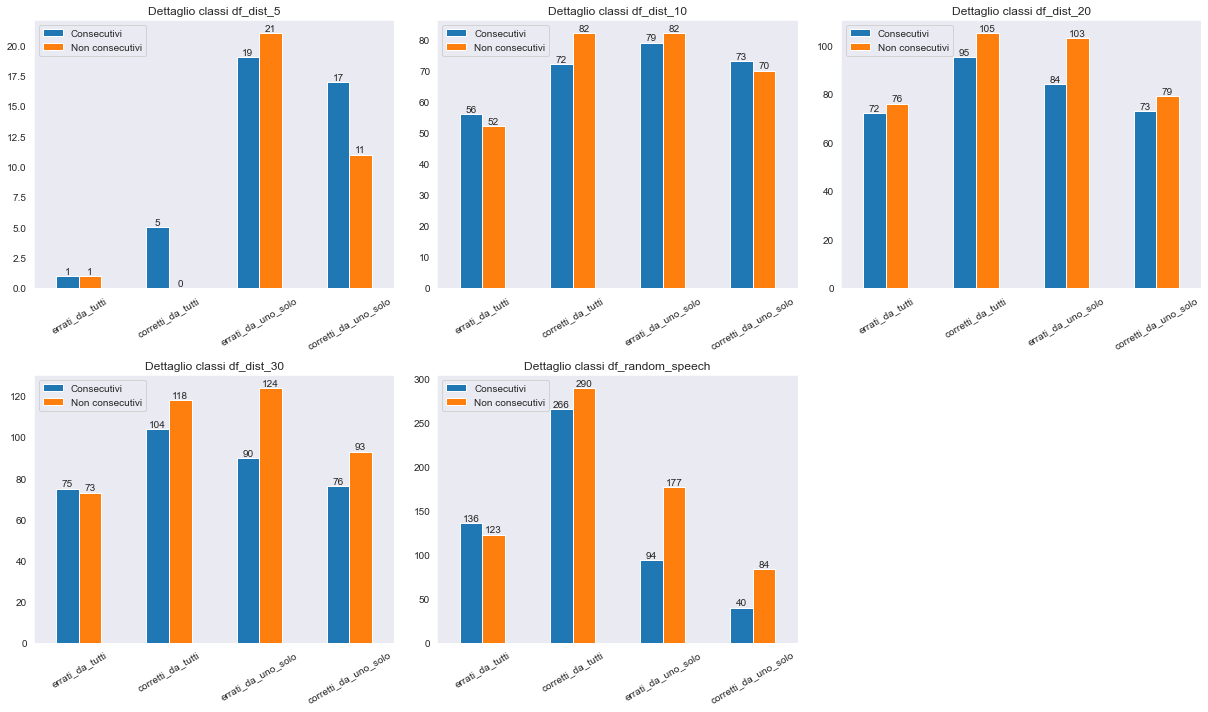

In [596]:
sns.set_style("dark")
fig, axs = plt.subplots(figsize=(17,10),nrows=2, ncols=3)
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_5'], orient='index').plot(ax=axs[0,0], kind='bar', color=['#1f77b4', '#ff7f0e'])
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_10'], orient='index').plot(ax=axs[0,1], kind='bar', color=['#1f77b4', '#ff7f0e'])
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_20'], orient='index').plot(ax=axs[0,2], kind='bar', color=['#1f77b4', '#ff7f0e'])
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_30'], orient='index').plot(ax=axs[1,0], kind='bar', color=['#1f77b4', '#ff7f0e'])
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_random_speech'], orient='index').plot(ax=axs[1,1], kind='bar', color=['#1f77b4', '#ff7f0e'])

fig.delaxes(axs[1][2])
for ax, dist in zip(axs.flat, lista_dist):
    for label in ax.containers:
        ax.bar_label(label, )
    
    # reordering the labels
    handles, labels = plt.gca().get_legend_handles_labels()
  
    # specify order
    order = [0,1]

    # pass handle & labels lists along with order as below
    ax.legend([handles[i] for i in order], [labels[i] for i in order], 
              labels=['Consecutivi', 'Non consecutivi'])
        
    ax.tick_params(axis='x', labelrotation=30)
    #ax.legend(loc='upper left', labels=['Consecutivi', 'Non consecutivi'])
    ax.set_title("Dettaglio classi {}".format(dist))


fig.tight_layout()
plt.show()

## Dettaglio classi SVM

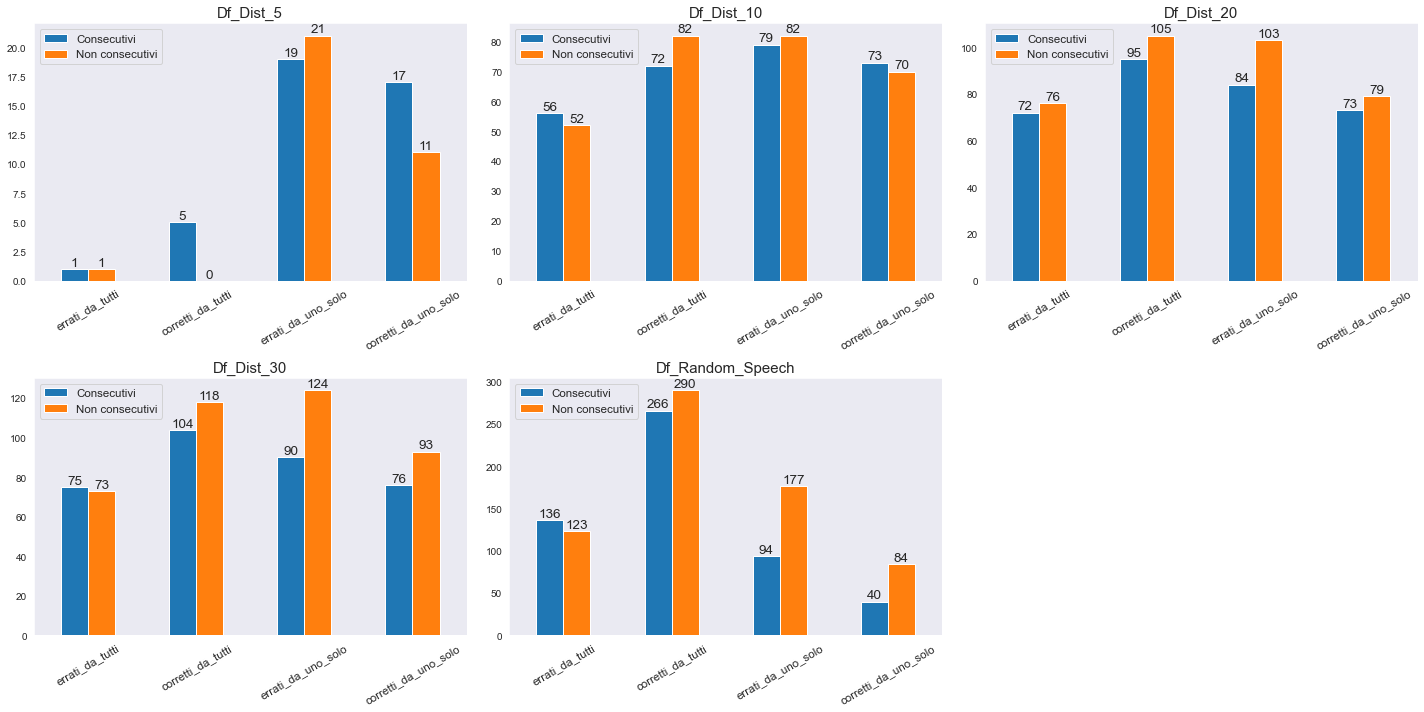

In [181]:
sns.set_style("dark")
fig, axs = plt.subplots(figsize=(20,10),nrows=2, ncols=3)
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_5'], orient='index').plot(ax=axs[0,0], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_10'], orient='index').plot(ax=axs[0,1], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_20'], orient='index').plot(ax=axs[0,2], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_30'], orient='index').plot(ax=axs[1,0], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_random_speech'], orient='index').plot(ax=axs[1,1], kind='bar')

fig.delaxes(axs[1][2])
for ax, dist in zip(axs.flat, lista_dist):
    for label in ax.containers:
        ax.bar_label(label, fontsize=13.5)
    
    ax.tick_params(axis='x', labelrotation=30, labelsize=11.5)
    ax.legend(loc='upper left', labels=['Consecutivi', 'Non consecutivi'], fontsize=11.5)
    ax.set_title("{}".format(dist).title(), fontsize=15)


fig.tight_layout()
title = "ParlaMint_dettaglio_classi_svm"
fig.savefig(path_images_tit_ridotti + title, dpi=fig.dpi, bbox_inches='tight')
plt.show()

Osservando tutti i grafici si nota subito che, mentre per la distanza 5 osserviamo più eventi classificati in modo errato o corretto da un solo classificatore e pochissime classificazioni in comune, per le altre distanze registriamo una situazione diversa, in particolare per la distanza random speech, in cui vediamo una prevalenza di classificazioni corrette da parte di tutti e una minoranza di classificazioni corrette o errate da parte di un solo classificatore. Per quanto concerne queste ultime, possiamo vedere che, in entrambi i casi, dominano gli eventi non consecutivi: nel caso delle classificazioni errate, questo indica che alcune frasi che eranno effettivamente cosecutive non sono state percepite come tali da un solo classificatore; nell'altro caso, invece, probabilmente si è trattato di frasi più complesse, in cui la mancanza di coerenza del loro accostamento è stata intercettata solo da un classificatore.
In merito alle altre distanze possiamo osservare che, all'aumentare delle distanza, cresce il numero di eventi non consecutivi classificati i modo corretto da tutti. Per tutte le distanze notiamo che, all'interno degli eventi classificati in modo errato da un solo classsificatore, prevale la classe 1, ciò significa che molto spesso un solo classificatore ha considerato non consecutivi eventi che invece lo erano. 

## Dettaglio classi Bert

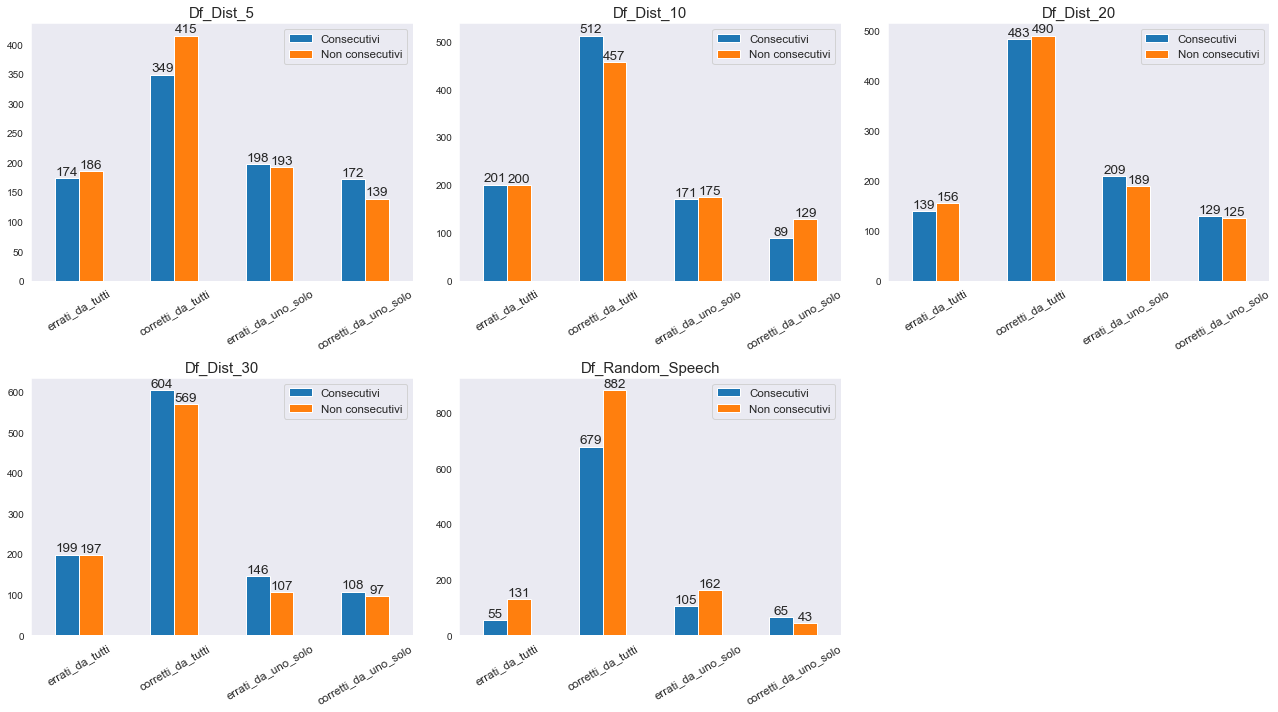

In [178]:
sns.set_style("dark")
fig, axs = plt.subplots(figsize=(17,10),nrows=2, ncols=3)
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_bert['df_dist_5'], orient='index').plot(ax=axs[0,0], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_bert['df_dist_10'], orient='index').plot(ax=axs[0,1], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_bert['df_dist_20'], orient='index').plot(ax=axs[0,2], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_bert['df_dist_30'], orient='index').plot(ax=axs[1,0], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_bert['df_random_speech'], orient='index').plot(ax=axs[1,1], kind='bar')

fig.delaxes(axs[1][2])

for ax, dist in zip(axs.flat, lista_dist):
    for label in ax.containers:
        ax.bar_label(label, fontsize=13.5)
  
    ax.tick_params(axis='x', labelrotation=30, labelsize=11.5)
    ax.legend(loc='upper right', labels=['Consecutivi', 'Non consecutivi'], fontsize=11.5)
    ax.set_title("{}".format(dist).title(), fontsize=15)

fig.tight_layout()
title = "ParlaMint_dettaglio_classi_bert"
fig.savefig(path_images_tit_ridotti + title, dpi=fig.dpi, bbox_inches='tight')
plt.show()

Osservando i grafici si nota che c'è una maggioranza di eventi classificati correttamente da tutte le epoche, con una prevalenza di eventi non consecutivi in particolare nella distanza random speech. Questo risultato probabilmente è dovuto al fatto che emerge più chiaramente l'incoerenza derivante dall'accostamento di due frasi appartenenti a interventi diversi.
In quest'ultimo caso, inoltre, si registra una minima parte di eventi classificati in modo errato o corretto da una sola epoca.
Per quanto concerne le altre distanze, non si nota una particolare diffferenza fra le due classi, in termini di classificazioni errate o corrette da una sola epoca o da tutte.

In [570]:
import matplotlib.colors as mcolors
print(mcolors.TABLEAU_COLORS)

{'tab:blue': '#1f77b4', 'tab:orange': '#ff7f0e', 'tab:green': '#2ca02c', 'tab:red': '#d62728', 'tab:purple': '#9467bd', 'tab:brown': '#8c564b', 'tab:pink': '#e377c2', 'tab:gray': '#7f7f7f', 'tab:olive': '#bcbd22', 'tab:cyan': '#17becf'}


In [71]:
diz_global_svm['df_dist_5']['clf_1']['diz_correct_events'][351014]

0

# Calcoliamo la percentuale di overlapping

In [113]:
lista_epoche

['Epoch0', 'Epoch1', 'Epoch2', 'Epoch3', 'Epoch4']

In [130]:
diz_totali_fp_fn_tp_tn_svm = {}

for distanza in lista_dist:
    diz_totali_fp_fn_tp_tn_svm[distanza] = {}
    totale_fp_fn_svm = 0
    totale_tp_tn_svm = 0
    for clf in lista_clf:
        totale_tp_tn_svm += len(diz_global_svm[distanza][clf]['diz_correct_events'])
        totale_fp_fn_svm += len(diz_global_svm[distanza][clf]['misclassified_events'])
    diz_totali_fp_fn_tp_tn_svm[distanza]['totale_tp_tn'] = totale_tp_tn_svm
    diz_totali_fp_fn_tp_tn_svm[distanza]['totale_fp_fn'] = totale_fp_fn_svm

In [131]:
diz_totali_fp_fn_tp_tn_bert = {}

for distanza in lista_dist:
    diz_totali_fp_fn_tp_tn_bert[distanza] = {}
    totale_fp_fn_bert = 0
    totale_tp_tn_bert = 0
    for epoca in lista_epoche:
        totale_tp_tn_bert += len(diz_global_bert[distanza][epoca]['diz_correct_events'])
        totale_fp_fn_bert += len(diz_global_bert[distanza][epoca]['misclassified_events'])
    diz_totali_fp_fn_tp_tn_bert[distanza]['totale_tp_tn'] = totale_tp_tn_bert
    diz_totali_fp_fn_tp_tn_bert[distanza]['totale_fp_fn'] = totale_fp_fn_bert

In [132]:
diz_totali_fp_fn_tp_tn_svm

{'df_dist_5': {'totale_tp_tn': 14335, 'totale_fp_fn': 14465},
 'df_dist_10': {'totale_tp_tn': 15050, 'totale_fp_fn': 13750},
 'df_dist_20': {'totale_tp_tn': 15243, 'totale_fp_fn': 13557},
 'df_dist_30': {'totale_tp_tn': 15311, 'totale_fp_fn': 13489},
 'df_random_speech': {'totale_tp_tn': 17356, 'totale_fp_fn': 11444}}

In [133]:
diz_totali_fp_fn_tp_tn_bert

{'df_dist_5': {'totale_tp_tn': 7115, 'totale_fp_fn': 4885},
 'df_dist_10': {'totale_tp_tn': 7633, 'totale_fp_fn': 4367},
 'df_dist_20': {'totale_tp_tn': 7945, 'totale_fp_fn': 4055},
 'df_dist_30': {'totale_tp_tn': 8038, 'totale_fp_fn': 3962},
 'df_random_speech': {'totale_tp_tn': 9699, 'totale_fp_fn': 2301}}

In [160]:
#calcolo percentuale della lunghezza di ogni insieme rispetto al totale, per tutti i livelli di complessità

def ottieni_percentuali(dizionario_intersezione_classificatori, list_df_test, diz_totali_fp_fn_tp_tn):
    
    dizionario_percentuali= {}
    
    for distanza, df_test in zip(dizionario_intersezione_classificatori, list_df_test):
    
        print(df_test.shape)
        
        dizionario_percentuali[distanza] = {}
        
        errati_da_tutti = dizionario_intersezione_classificatori[distanza]['intersection_misclassified']
        corretti_da_tutti = dizionario_intersezione_classificatori[distanza]['intersection_correct']
        errati_da_uno_solo = dizionario_intersezione_classificatori[distanza]['other_events_misclassified']
        corretti_da_uno_solo = dizionario_intersezione_classificatori[distanza]['other_events_correct']
        
        print(distanza)
        print("errati_da_tutti", len(errati_da_tutti))
        print("corretti_da_tutti", len(corretti_da_tutti))
        print("errati_da_uno_solo", len(errati_da_uno_solo))
        print("corretti_da_uno_solo", len(corretti_da_uno_solo))
        print()
        print("totale_fp_fn", diz_totali_fp_fn_tp_tn[distanza]['totale_fp_fn'])
        print("totale_tp_tn", diz_totali_fp_fn_tp_tn[distanza]['totale_tp_tn'])
        print()
        
        perc_errati_da_tutti_su_totale_classificati = (len(errati_da_tutti) * 100) / df_test.shape[0]
        perc_corretti_da_tutti_su_totale_classificati = (len(corretti_da_tutti) * 100) / df_test.shape[0]
        perc_errati_da_uno_solo_su_totale_classificati = (len(errati_da_uno_solo) * 100) / df_test.shape[0]
        perc_corretti_da_uno_solo_su_totale_classificati = (len(corretti_da_uno_solo) * 100) / df_test.shape[0]
        
        #perc_errati_da_tutti_su_totale_fp_fn = (len(errati_da_tutti) * 100) / diz_totali_fp_fn_tp_tn[distanza]['totale_fp_fn']
        #perc_corretti_da_tutti_su_totale_tp_tn = (len(corretti_da_tutti) * 100) / diz_totali_fp_fn_tp_tn[distanza]['totale_tp_tn']
        #perc_errati_da_uno_solo_su_totale_fp_fn = (len(errati_da_uno_solo) * 100) / diz_totali_fp_fn_tp_tn[distanza]['totale_fp_fn']
        #perc_corretti_da_uno_solo_su_totale_tp_tn = (len(corretti_da_uno_solo) * 100) / diz_totali_fp_fn_tp_tn[distanza]['totale_tp_tn']
        
        dizionario_percentuali[distanza]['perc_errati_da_tutti_su_totale_classificati'] = "%.2f" % perc_errati_da_tutti_su_totale_classificati + "%"
        dizionario_percentuali[distanza]['perc_corretti_da_tutti_su_totale_classificati'] = "%.2f" % perc_corretti_da_tutti_su_totale_classificati + "%"
        dizionario_percentuali[distanza]['perc_errati_da_uno_solo_su_totale_classificati'] = "%.2f" % perc_errati_da_uno_solo_su_totale_classificati + "%"
        dizionario_percentuali[distanza]['perc_corretti_da_uno_solo_su_totale_classificati'] = "%.2f" % perc_corretti_da_uno_solo_su_totale_classificati + "%"
        
        #dizionario_percentuali[distanza]['perc_errati_da_tutti_su_totale_fp_fn'] = "%.2f" % perc_errati_da_tutti_su_totale_fp_fn + "%"
        #dizionario_percentuali[distanza]['perc_corretti_da_tutti_su_totale_tp_tn'] = "%.2f" % perc_corretti_da_tutti_su_totale_tp_tn + "%"
        #dizionario_percentuali[distanza]['perc_errati_da_uno_solo_su_totale_fp_fn'] = "%.2f" % perc_errati_da_uno_solo_su_totale_fp_fn + "%"
        #dizionario_percentuali[distanza]['perc_corretti_da_uno_solo_su_totale_tp_tn'] = "%.2f" % perc_corretti_da_uno_solo_su_totale_tp_tn + "%"
        
    return dizionario_percentuali

In [161]:
diz_percentuali_svm = ottieni_percentuali(diz_intersections_svm, lista_df_test, diz_totali_fp_fn_tp_tn_svm)

NameError: name 'diz_totali_fp_fn_tp_tn_svm' is not defined

In [162]:
diz_percentuali_bert = ottieni_percentuali(diz_intersections_bert, lista_df_test, diz_totali_fp_fn_tp_tn_bert)

NameError: name 'diz_totali_fp_fn_tp_tn_bert' is not defined

In [610]:
diz_percentuali_svm

{'df_dist_5': {'perc_errati_da_tutti_su_totale_classificati': '0.08%',
  'perc_corretti_da_tutti_su_totale_classificati': '0.21%',
  'perc_errati_da_uno_solo_su_totale_classificati': '1.67%',
  'perc_corretti_da_uno_solo_su_totale_classificati': '1.17%'},
 'df_dist_10': {'perc_errati_da_tutti_su_totale_classificati': '4.50%',
  'perc_corretti_da_tutti_su_totale_classificati': '6.42%',
  'perc_errati_da_uno_solo_su_totale_classificati': '6.71%',
  'perc_corretti_da_uno_solo_su_totale_classificati': '5.96%'},
 'df_dist_20': {'perc_errati_da_tutti_su_totale_classificati': '6.17%',
  'perc_corretti_da_tutti_su_totale_classificati': '8.33%',
  'perc_errati_da_uno_solo_su_totale_classificati': '7.79%',
  'perc_corretti_da_uno_solo_su_totale_classificati': '6.33%'},
 'df_dist_30': {'perc_errati_da_tutti_su_totale_classificati': '6.17%',
  'perc_corretti_da_tutti_su_totale_classificati': '9.25%',
  'perc_errati_da_uno_solo_su_totale_classificati': '8.92%',
  'perc_corretti_da_uno_solo_su_total

In [611]:
diz_percentuali_bert

{'df_dist_5': {'perc_errati_da_tutti_su_totale_classificati': '15.00%',
  'perc_corretti_da_tutti_su_totale_classificati': '31.83%',
  'perc_errati_da_uno_solo_su_totale_classificati': '16.29%',
  'perc_corretti_da_uno_solo_su_totale_classificati': '12.96%'},
 'df_dist_10': {'perc_errati_da_tutti_su_totale_classificati': '16.71%',
  'perc_corretti_da_tutti_su_totale_classificati': '40.38%',
  'perc_errati_da_uno_solo_su_totale_classificati': '14.42%',
  'perc_corretti_da_uno_solo_su_totale_classificati': '9.08%'},
 'df_dist_20': {'perc_errati_da_tutti_su_totale_classificati': '12.29%',
  'perc_corretti_da_tutti_su_totale_classificati': '40.54%',
  'perc_errati_da_uno_solo_su_totale_classificati': '16.58%',
  'perc_corretti_da_uno_solo_su_totale_classificati': '10.58%'},
 'df_dist_30': {'perc_errati_da_tutti_su_totale_classificati': '16.50%',
  'perc_corretti_da_tutti_su_totale_classificati': '48.88%',
  'perc_errati_da_uno_solo_su_totale_classificati': '10.54%',
  'perc_corretti_da_uno

In [612]:
df_perc_svm = pd.DataFrame(diz_percentuali_svm).T

df_perc_svm.rename(columns={'classificati_in_modo_sbagliato_da_tutti':"Eventi classificati in modo errato da tutti", \
                         'classificati_correttamente_da_tutti': "Eventi classificati in modo corretto da tutti", \
                          'classificati_in_modo_sbagliato_da_uno_solo': "Eventi classificati in modo errato da uno solo", \
                          'classificati_correttamente_da_uno_solo': "Eventi classificati in modo corretto da uno solo"}, 
                  inplace=True)

In [613]:
df_perc_svm

,perc_errati_da_tutti_su_totale_classificati,perc_corretti_da_tutti_su_totale_classificati,perc_errati_da_uno_solo_su_totale_classificati,perc_corretti_da_uno_solo_su_totale_classificati
df_dist_5,0.08%,0.21%,1.67%,1.17%
df_dist_10,4.50%,6.42%,6.71%,5.96%
df_dist_20,6.17%,8.33%,7.79%,6.33%
df_dist_30,6.17%,9.25%,8.92%,7.04%
df_random_speech,10.79%,23.17%,11.29%,5.17%


Possiamo notare che, per tutte le casistiche, c'è una vicinanza fra lele percentuali per le distanze 20 e 30, mentre osserviamo valori inferiori per la distannza 10. Per quanto riguarda il livello di complessità più basso (distanza 5) osserviamo valori molto bassi.
Per quanto concerne la distanza random speech, si registra una percentuale di eventi classificati in modo corretto da tutti i classificatori superiore a quella degli eventi la cui classificazione è risultata errata per tutti. Tale dato è superiore anche rispetto agli eventi classificati in modo errato o corretto da un solo classificatore.

In [614]:
df_perc_bert = pd.DataFrame(diz_percentuali_bert).T

df_perc_bert.rename(columns={'classificati_in_modo_sbagliato_da_tutti':"Eventi classificati in modo errato da tutte", \
                         'classificati_correttamente_da_tutti': "Eventi classificati in modo corretto da tutte", \
                          'classificati_in_modo_sbagliato_da_uno_solo': "Eventi classificati in modo errato da una sola", \
                          'classificati_correttamente_da_uno_solo': "Eventi classificati in modo corretto da una sola"}, 
                  inplace=True)

In [615]:
df_perc_bert

,perc_errati_da_tutti_su_totale_classificati,perc_corretti_da_tutti_su_totale_classificati,perc_errati_da_uno_solo_su_totale_classificati,perc_corretti_da_uno_solo_su_totale_classificati
df_dist_5,15.00%,31.83%,16.29%,12.96%
df_dist_10,16.71%,40.38%,14.42%,9.08%
df_dist_20,12.29%,40.54%,16.58%,10.58%
df_dist_30,16.50%,48.88%,10.54%,8.54%
df_random_speech,7.75%,65.04%,11.12%,4.50%


A un primo sguardo, risulta subito evidente che, a prescindere dai livelli di complessità, osserviamo dei valori percentuali più alti per gli eventi corretti da tutte le epoche, rispetto a quelli errati da tutte, in modo particolare per la distanza random speech (come atteso). Non c'è una differenza rilevante fra le varie distanze per quanto riguarda le percentuali di eventi classificati in modo sbagliato da una sola epoca, sebbene si riscontri qualche valore più alto per la distanza 5 e 20. In merito agli eventi classificati in moddo corretto da una sola epoca notiamo che il valore più alto è ddimostrato dalla distanza 5, seguita alla 20, mentre per la random speech troviamo il valore più basso.


In [616]:
save_dataframe('df_perc_svm', df_perc_svm)

File salvato correttamente


In [617]:
save_dataframe('df_perc_bert', df_perc_bert)

File salvato correttamente


In [188]:
# per ogni distanza calcolo la percentuale di TP/FP e TN/FN sul totale di eventi classificati correttamente o meno
# da tutti i classificatori o da tutte le epoche

def ottieni_percentuali_tp_fp_tn_fn(dizionario_classificatori, list_df_test, diz_global, lista_clf_epoch, modello):
    
    dizionario_percentuali = {}
    
    for distanza, df_test in zip(dizionario_classificatori, list_df_test):
    
        print("Distanza {} - test shape: {}".format(distanza, df_test.shape))
        print()
        dizionario_percentuali[distanza] = {}
        
        errati_da_tutti = dizionario_classificatori[distanza]['intersection_misclassified']
        corretti_da_tutti = dizionario_classificatori[distanza]['intersection_correct']
        errati_da_uno_solo = dizionario_classificatori[distanza]['other_events_misclassified']
        corretti_da_uno_solo = dizionario_classificatori[distanza]['other_events_correct']
        
        dizionario_errati_corretti = {}
        dizionario_errati_corretti['errati_da_tutti'] = errati_da_tutti
        dizionario_errati_corretti['corretti_da_tutti'] = corretti_da_tutti
        dizionario_errati_corretti['errati_da_uno_solo'] = errati_da_uno_solo
        dizionario_errati_corretti['corretti_da_uno_solo'] = corretti_da_uno_solo
        
        diz_tp_fp_tn_fn = get_liste_tp_fp_tn_fn(distanza, \
                                                dizionario_errati_corretti, \
                                                diz_global, \
                                                lista_clf_epoch, \
                                                dizionario_errati_corretti, modello)
        
        for chiave in dizionario_errati_corretti:
            dizionario_percentuali[distanza][chiave] = {}
            dizionario_percentuali[distanza][chiave]['percentuale_consecutivi'] = "%.2f" % diz_tp_fp_tn_fn[chiave]['percentuale_consecutivi'] + "%"
            dizionario_percentuali[distanza][chiave]['percentuale_non_consecutivi'] = "%.2f" % diz_tp_fp_tn_fn[chiave]['percentuale_non_consecutivi'] + "%"
        
        print()
        
    return dizionario_percentuali

In [189]:
def get_liste_tp_fp_tn_fn(distanza, dizionario_intersezioni_classificatori, diz_global, lista_clf_epoch, \
                          dizionario_errati_corretti, modello):
    
    diz_tp_fp_tn_fn = {}
    
    if modello == 'svm':
        num_classificazioni_comuni = 12
    else:
        num_classificazioni_comuni = 5
    
    for chiave in dizionario_errati_corretti:
        
        diz_tp_fp_tn_fn[chiave] = {}
        
        consecutivi = []
        non_consecutivi = []
        
        # per ogni chiave voglio la quantità di esempi non_consecutivi e consecutivi rispetto al totale
        for evento in dizionario_errati_corretti[chiave]:
            
            # False Positive / False Negative
            if chiave == 'errati_da_tutti':
                lista_esiti_clf = []
                
                for clf_epoch in lista_clf_epoch:
                    esito_evento = diz_global[distanza][clf_epoch]['misclassified_events'][evento]
                    
                    if esito_evento['new_value'] == esito_evento['old_value']:
                        print("Errore errati_da_tutti! Ho trovato esempi uguali per l'evento {} (complessità {})".format(evento, \
                                                                                                          distanza))
                    lista_esiti_clf.append(esito_evento['new_value'])
                
                if len(lista_esiti_clf) != num_classificazioni_comuni:
                    print(lista_esiti_clf)
                    print("Errore errati_da_tutti! la lista delle classificazioni non e' di lunghezza pari a {}!".format(num_classificazioni_comuni))
                
                lista_esiti_clf = set(lista_esiti_clf)
                if len(lista_esiti_clf) > 1:
                    print(lista_esiti_clf)
                    print("Errore errati_da_tutti! Ho trovato esempi uguali per l'evento {} (complessità {} e clf {})".format(evento,distanza, clf_epoch))
                else:
                    esito_evento = list(lista_esiti_clf)[0]
                    if esito_evento == 1:
                        non_consecutivi.append(evento)
                    elif esito_evento == 0:
                        consecutivi.append(evento)
            
            # True Positive / True Negative
            elif chiave == 'corretti_da_tutti':
                lista_esiti_clf = []

                for clf_epoch in lista_clf_epoch:
                    esito_evento = diz_global[distanza][clf_epoch]['diz_correct_events'][evento]
                    if esito_evento == None:
                        print("Errore! Non ho trovato l'evento {} per il classificatore {}".format(evento, clf_epoch))
                    else:
                        lista_esiti_clf.append(esito_evento)
                    
                if len(lista_esiti_clf) != num_classificazioni_comuni:
                    print(lista_esiti_clf)
                    print("Errore corretti_da_tutti! la lista delle classificazioni non e' di lunghezza pari a {}!".format(num_classificazioni_comuni))
                
                lista_esiti_clf = set(lista_esiti_clf)
                if len(lista_esiti_clf) > 1:
                    print(lista_esiti_clf)
                    print("Errore corretti_da_tutti! Ho trovato esempi uguali per l'evento {} (complessità {} e clf {})".format(evento,distanza, clf_epoch))
                else:
                    esito_evento = list(lista_esiti_clf)[0]
                    if esito_evento == 1:
                        non_consecutivi.append(evento)
                    elif esito_evento == 0:
                        consecutivi.append(evento)
                    
            elif chiave == 'errati_da_uno_solo':
                lista_esiti_clf = []
                
                for clf_epoch in lista_clf_epoch:
                    if diz_global[distanza][clf_epoch]['misclassified_events'].get(evento):
                        esito_evento = diz_global[distanza][clf_epoch]['misclassified_events'][evento]
                        lista_esiti_clf.append(esito_evento['new_value'])
                        
                if len(lista_esiti_clf) > 1:
                    #print(lista_esiti_clf)
                    print("Errore errati_da_uno_solo! Ho trovato esempi uguali per l'evento {} (complessità {} e clf {})".format(evento,distanza, clf_epoch))
                elif len(lista_esiti_clf) == 0:
                    print("Errore errati_da_uno_solo! lista vuota! {} (complessità {} e clf {})".format(evento,distanza, clf_epoch))
                else:
                    esito_evento = lista_esiti_clf[0]
                    if esito_evento == 1:
                        non_consecutivi.append(evento)
                    elif esito_evento == 0:
                        consecutivi.append(evento)
                        
            elif chiave == 'corretti_da_uno_solo':
                lista_esiti_clf = []
                
                for clf_epoch in lista_clf_epoch:
                    result = diz_global[distanza][clf_epoch]['diz_correct_events'].get(evento)
                    if result != None:
                        esito_evento = result
                        lista_esiti_clf.append(esito_evento)
        
                if len(lista_esiti_clf) > 1:
                    print("Errore corretti_da_uno_solo! Ho trovato esempi uguali per l'evento {} (complessità {} e clf {})".format(evento,distanza, clf_epoch))
                elif len(lista_esiti_clf) == 0:
                    print("Errore corretti_da_uno_solo! lista vuota! {} (complessità {} e clf {})".format(evento,distanza, clf_epoch))
                else:
                    esito_evento = lista_esiti_clf[0]
                    if esito_evento == 1:
                        non_consecutivi.append(evento)
                    elif esito_evento == 0:
                        consecutivi.append(evento)
        
        print("{}: {} ----> consecutivi({}) + non_consecutivi({}) = {}".format(chiave, \
                                                                    len(dizionario_errati_corretti[chiave]), \
                                                                    len(consecutivi), \
                                                                    len(non_consecutivi), \
                                                                    len(consecutivi)+len(non_consecutivi)))
        diz_tp_fp_tn_fn[chiave]['consecutivi'] = consecutivi
        diz_tp_fp_tn_fn[chiave]['non_consecutivi'] = non_consecutivi
        diz_tp_fp_tn_fn[chiave]['percentuale_consecutivi'] = (len(consecutivi) * 100) / len(dizionario_errati_corretti[chiave])
        diz_tp_fp_tn_fn[chiave]['percentuale_non_consecutivi'] = (len(non_consecutivi) * 100) / len(dizionario_errati_corretti[chiave])
              
    return diz_tp_fp_tn_fn

In [190]:
percentuali_tp_fp_tn_fn_svm = ottieni_percentuali_tp_fp_tn_fn(diz_intersections_svm, lista_df_test, \
                                                              diz_global_svm, lista_clf, 'svm')

Distanza df_dist_5 - test shape: (2400, 4)

errati_da_tutti: 2 ----> consecutivi(1) + non_consecutivi(1) = 2
corretti_da_tutti: 5 ----> consecutivi(5) + non_consecutivi(0) = 5
errati_da_uno_solo: 40 ----> consecutivi(19) + non_consecutivi(21) = 40
corretti_da_uno_solo: 28 ----> consecutivi(17) + non_consecutivi(11) = 28

Distanza df_dist_10 - test shape: (2400, 4)

errati_da_tutti: 108 ----> consecutivi(56) + non_consecutivi(52) = 108
corretti_da_tutti: 154 ----> consecutivi(72) + non_consecutivi(82) = 154
errati_da_uno_solo: 161 ----> consecutivi(79) + non_consecutivi(82) = 161
corretti_da_uno_solo: 143 ----> consecutivi(73) + non_consecutivi(70) = 143

Distanza df_dist_20 - test shape: (2400, 4)

errati_da_tutti: 148 ----> consecutivi(72) + non_consecutivi(76) = 148
corretti_da_tutti: 200 ----> consecutivi(95) + non_consecutivi(105) = 200
errati_da_uno_solo: 187 ----> consecutivi(84) + non_consecutivi(103) = 187
corretti_da_uno_solo: 152 ----> consecutivi(73) + non_consecutivi(79) = 

In [191]:
percentuali_tp_fp_tn_fn_bert = ottieni_percentuali_tp_fp_tn_fn(diz_intersections_bert, lista_df_test, \
                                                              diz_global_bert, lista_epoche, 'bert')

Distanza df_dist_5 - test shape: (2400, 4)

errati_da_tutti: 360 ----> consecutivi(174) + non_consecutivi(186) = 360
corretti_da_tutti: 764 ----> consecutivi(349) + non_consecutivi(415) = 764
errati_da_uno_solo: 391 ----> consecutivi(198) + non_consecutivi(193) = 391
corretti_da_uno_solo: 311 ----> consecutivi(172) + non_consecutivi(139) = 311

Distanza df_dist_10 - test shape: (2400, 4)

errati_da_tutti: 401 ----> consecutivi(201) + non_consecutivi(200) = 401
corretti_da_tutti: 969 ----> consecutivi(512) + non_consecutivi(457) = 969
errati_da_uno_solo: 346 ----> consecutivi(171) + non_consecutivi(175) = 346
corretti_da_uno_solo: 218 ----> consecutivi(89) + non_consecutivi(129) = 218

Distanza df_dist_20 - test shape: (2400, 4)

errati_da_tutti: 295 ----> consecutivi(139) + non_consecutivi(156) = 295
corretti_da_tutti: 973 ----> consecutivi(483) + non_consecutivi(490) = 973
errati_da_uno_solo: 398 ----> consecutivi(209) + non_consecutivi(189) = 398
corretti_da_uno_solo: 254 ----> conse

In [192]:
df_perc_svm_specifica_perc = pd.DataFrame.from_dict({(i,j): percentuali_tp_fp_tn_fn_svm[i][j] 
                           for i in percentuali_tp_fp_tn_fn_svm.keys() 
                           for j in percentuali_tp_fp_tn_fn_svm[i].keys()},
                       orient='index')

In [194]:
df_perc_svm_specifica_perc

percentuale_consecutivi  \
df_dist_5        errati_da_tutti                       50.00%   
                 corretti_da_tutti                    100.00%   
                 errati_da_uno_solo                    47.50%   
                 corretti_da_uno_solo                  60.71%   
df_dist_10       errati_da_tutti                       51.85%   
                 corretti_da_tutti                     46.75%   
                 errati_da_uno_solo                    49.07%   
                 corretti_da_uno_solo                  51.05%   
df_dist_20       errati_da_tutti                       48.65%   
                 corretti_da_tutti                     47.50%   
                 errati_da_uno_solo                    44.92%   
                 corretti_da_uno_solo                  48.03%   
df_dist_30       errati_da_tutti                       50.68%   
                 corretti_da_tutti                     46.85%   
                 errati_da_uno_solo                    42.06%   
                 corretti_da_uno_solo                  44.97%   
df_random_speech errati_da_tutti                       52.51%   
                 corretti_da_tutti                     47.84%   
                 errati_da_uno_solo                    34.69%   
                 corretti_da_uno_solo                  32.26%   

                                      percentuale_non_consecutivi  
df_dist_5        errati_da_tutti                           50.00%  
                 corretti_da_tutti                          0.00%  
                 errati_da_uno_solo                        52.50%  
                 corretti_da_uno_solo                      39.29%  
df_dist_10       errati_da_tutti                           48.15%  
                 corretti_da_tutti                         53.25%  
                 errati_da_uno_solo                        50.93%  
                 corretti_da_uno_solo                      48.95%  
df_dist_20       errati_da_tutti                           51.35%  
                 corretti_da_tutti                         52.50%  
                 errati_da_uno_solo                        55.08%  
                 corretti_da_uno_solo                      51.97%  
df_dist_30       errati_da_tutti                           49.32%  
                 corretti_da_tutti                         53.15%  
                 errati_da_uno_solo                        57.94%  
                 corretti_da_uno_solo                      55.03%  
df_random_speech errati_da_tutti                           47.49%  
                 corretti_da_tutti                         52.16%  
                 errati_da_uno_solo                        65.31%  
                 corretti_da_uno_solo                      67.74%

In [193]:
df_perc_bert_specifica_perc = pd.DataFrame.from_dict({(i,j): percentuali_tp_fp_tn_fn_bert[i][j] 
                           for i in percentuali_tp_fp_tn_fn_bert.keys() 
                           for j in percentuali_tp_fp_tn_fn_bert[i].keys()},
                       orient='index')

In [195]:
df_perc_bert_specifica_perc

percentuale_consecutivi  \
df_dist_5        errati_da_tutti                       48.33%   
                 corretti_da_tutti                     45.68%   
                 errati_da_uno_solo                    50.64%   
                 corretti_da_uno_solo                  55.31%   
df_dist_10       errati_da_tutti                       50.12%   
                 corretti_da_tutti                     52.84%   
                 errati_da_uno_solo                    49.42%   
                 corretti_da_uno_solo                  40.83%   
df_dist_20       errati_da_tutti                       47.12%   
                 corretti_da_tutti                     49.64%   
                 errati_da_uno_solo                    52.51%   
                 corretti_da_uno_solo                  50.79%   
df_dist_30       errati_da_tutti                       50.25%   
                 corretti_da_tutti                     51.49%   
                 errati_da_uno_solo                    57.71%   
                 corretti_da_uno_solo                  52.68%   
df_random_speech errati_da_tutti                       29.57%   
                 corretti_da_tutti                     43.50%   
                 errati_da_uno_solo                    39.33%   
                 corretti_da_uno_solo                  60.19%   

                                      percentuale_non_consecutivi  
df_dist_5        errati_da_tutti                           51.67%  
                 corretti_da_tutti                         54.32%  
                 errati_da_uno_solo                        49.36%  
                 corretti_da_uno_solo                      44.69%  
df_dist_10       errati_da_tutti                           49.88%  
                 corretti_da_tutti                         47.16%  
                 errati_da_uno_solo                        50.58%  
                 corretti_da_uno_solo                      59.17%  
df_dist_20       errati_da_tutti                           52.88%  
                 corretti_da_tutti                         50.36%  
                 errati_da_uno_solo                        47.49%  
                 corretti_da_uno_solo                      49.21%  
df_dist_30       errati_da_tutti                           49.75%  
                 corretti_da_tutti                         48.51%  
                 errati_da_uno_solo                        42.29%  
                 corretti_da_uno_solo                      47.32%  
df_random_speech errati_da_tutti                           70.43%  
                 corretti_da_tutti                         56.50%  
                 errati_da_uno_solo                        60.67%  
                 corretti_da_uno_solo                      39.81%

In [ ]:
save_dataframe('df_perc_svm_specifica_perc', df_perc_svm_specifica_perc)

In [ ]:
save_dataframe('df_perc_bert_specifica_perc', df_perc_bert_specifica_perc)

### Selezioniamo alcuni esempi di eventi da mostrare per i confronti interni ai modelli

In [30]:
def get_interventi_scelti_intersezione_confronti_interni(diz, lista_dist):
    
    diz_dist = {}
    
    for dist in lista_dist:
        
        diz_dist[dist] = {}
        
        #classificati bene o male da tutti i clf o epoche
        try:
            lista_eventi_scelti_intersezione_errati = random.sample(diz[dist]['intersection_misclassified'], 4)
        except:
            lista_eventi_scelti_intersezione_errati = random.sample(diz[dist]['intersection_misclassified'], 2)
        lista_eventi_scelti_intersezione_corretti = random.sample(diz[dist]['intersection_correct'], 4)
         
        #classificati bene o male solo da un clf o un'epoca
        lista_eventi_scelti_intersezione_altri_errati = random.sample(diz[dist]['other_events_misclassified'], 4)
        lista_eventi_scelti_intersezione_altri_corretti = random.sample(diz[dist]['other_events_correct'], 4)
        
        diz_dist[dist]['lista_eventi_scelti_intersezione_errati'] = lista_eventi_scelti_intersezione_errati
        diz_dist[dist]['lista_eventi_scelti_intersezione_corretti'] = lista_eventi_scelti_intersezione_corretti
        diz_dist[dist]['lista_eventi_scelti_intersezione_altri_errati'] = lista_eventi_scelti_intersezione_altri_errati
        diz_dist[dist]['lista_eventi_scelti_intersezione_altri_corretti'] = lista_eventi_scelti_intersezione_altri_corretti
        
    return diz_dist

In [31]:
diz_dist_svm_table = get_interventi_scelti_intersezione_confronti_interni(diz_intersections_svm, lista_dist)

In [32]:
diz_dist_bert_table = get_interventi_scelti_intersezione_confronti_interni(diz_intersections_bert, lista_dist)

### Selezioniamo alcuni esempi da mostrare per i confronti incrociati, ovvero prendiamo alcuni esempi di eventi classificati bene o male da tutti i clf o le epoche dei differenti modelli e confrontiamo i risultati delle classificazioni

In [36]:
def get_confronti_incrociati(lista_dist, diz_svm, diz_bert):
    
    diz_confronti_incrociati = {}
    
    for dist in lista_dist:
        
        diz_confronti_incrociati[dist] = {}
        
        diz_confronti_incrociati[dist]['lista_eventi_scelti_intersezione_errati'] = []
        diz_confronti_incrociati[dist]['lista_eventi_scelti_intersezione_corretti'] = []
        
        try:
            eventi_classificati_male_svm = random.sample(diz_svm[dist]['lista_eventi_scelti_intersezione_errati'], 3)
        except:
            eventi_classificati_male_svm = random.sample(diz_svm[dist]['lista_eventi_scelti_intersezione_errati'], 2)
            
        eventi_classificati_male_bert = random.sample(diz_bert[dist]['lista_eventi_scelti_intersezione_errati'], 3)
        
        eventi_classificati_bene_svm = random.sample(diz_svm[dist]['lista_eventi_scelti_intersezione_corretti'], 3)
        eventi_classificati_bene_bert = random.sample(diz_svm[dist]['lista_eventi_scelti_intersezione_corretti'], 3)
        
        diz_confronti_incrociati[dist]['lista_eventi_scelti_intersezione_errati'].extend(eventi_classificati_male_svm)
        diz_confronti_incrociati[dist]['lista_eventi_scelti_intersezione_errati'].extend(eventi_classificati_male_bert)
        
        diz_confronti_incrociati[dist]['lista_eventi_scelti_intersezione_corretti'].extend(eventi_classificati_bene_svm)
        diz_confronti_incrociati[dist]['lista_eventi_scelti_intersezione_corretti'].extend(eventi_classificati_bene_bert)
        
        
    return diz_confronti_incrociati

In [37]:
diz_confronti_incrociati = get_confronti_incrociati(lista_dist, diz_dist_svm_table, diz_dist_bert_table)

In [38]:
diz_confronti_incrociati

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': [228695,
   195285,
   330672,
   747146,
   360018],
  'lista_eventi_scelti_intersezione_corretti': [414778,
   464910,
   537330,
   537330,
   518453,
   464910]},
 'df_dist_10': {'lista_eventi_scelti_intersezione_errati': [493852,
   425573,
   792573,
   614377,
   525624,
   332430],
  'lista_eventi_scelti_intersezione_corretti': [182710,
   462203,
   332302,
   828348,
   462203,
   332302]},
 'df_dist_20': {'lista_eventi_scelti_intersezione_errati': [604608,
   578568,
   670427,
   448386,
   382168,
   382335],
  'lista_eventi_scelti_intersezione_corretti': [453760,
   141615,
   20411,
   141615,
   453760,
   673095]},
 'df_dist_30': {'lista_eventi_scelti_intersezione_errati': [791038,
   451088,
   880161,
   282654,
   793878,
   237514],
  'lista_eventi_scelti_intersezione_corretti': [453798,
   276356,
   318497,
   276356,
   453798,
   318497]},
 'df_random_speech': {'lista_eventi_scelti_intersezione_errati': 

In [39]:
diz_dist_svm_table

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': [228695, 195285],
  'lista_eventi_scelti_intersezione_corretti': [518453,
   464910,
   537330,
   414778],
  'lista_eventi_scelti_intersezione_altri_errati': [5733,
   557954,
   368710,
   45684],
  'lista_eventi_scelti_intersezione_altri_corretti': [124516,
   260309,
   440791,
   50850]},
 'df_dist_10': {'lista_eventi_scelti_intersezione_errati': [401691,
   792573,
   425573,
   493852],
  'lista_eventi_scelti_intersezione_corretti': [462203,
   828348,
   182710,
   332302],
  'lista_eventi_scelti_intersezione_altri_errati': [798681,
   516959,
   68621,
   158019],
  'lista_eventi_scelti_intersezione_altri_corretti': [35436,
   343745,
   512339,
   886124]},
 'df_dist_20': {'lista_eventi_scelti_intersezione_errati': [670427,
   214010,
   578568,
   604608],
  'lista_eventi_scelti_intersezione_corretti': [141615, 453760, 673095, 20411],
  'lista_eventi_scelti_intersezione_altri_errati': [229837,
   495658,
   329309,
  

In [40]:
diz_dist_bert_table

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': [717398,
   360018,
   330672,
   747146],
  'lista_eventi_scelti_intersezione_corretti': [173046,
   461426,
   548144,
   530704],
  'lista_eventi_scelti_intersezione_altri_errati': [529548,
   148614,
   892241,
   604431],
  'lista_eventi_scelti_intersezione_altri_corretti': [290747,
   849431,
   718961,
   638696]},
 'df_dist_10': {'lista_eventi_scelti_intersezione_errati': [614377,
   525624,
   59000,
   332430],
  'lista_eventi_scelti_intersezione_corretti': [869894,
   266866,
   299153,
   712164],
  'lista_eventi_scelti_intersezione_altri_errati': [227766,
   410469,
   297067,
   413538],
  'lista_eventi_scelti_intersezione_altri_corretti': [269460,
   241066,
   760651,
   218140]},
 'df_dist_20': {'lista_eventi_scelti_intersezione_errati': [145772,
   448386,
   382168,
   382335],
  'lista_eventi_scelti_intersezione_corretti': [750527, 247257, 22567, 715746],
  'lista_eventi_scelti_intersezione_altri_errati': [23

In [41]:
a = {'eleonora': {'prova': 1, 'ciao': 2}}

pd.DataFrame.from_dict(a, orient='index', columns=['prova', 'ciao'])

,prova,ciao
eleonora,1,2


In [42]:
def costruisci_tabella_confronti_interni(diz_eventi_scelti, lista_dist, clf_epoch_list, \
                                         lista_df_test, lista_diz_pred):
    
    diz_total = {}
    
    for df_test, dist, diz_pred in tqdm(zip(lista_df_test, lista_dist, lista_diz_pred)):
        
        diz_total[dist] = {}
        
        for key in diz_eventi_scelti[dist]:
            
            diz_total[dist][key] = {}
            
            for evento in diz_eventi_scelti[dist][key]:
                val = df_test[df_test['Id'] == evento][['Sentence_1', 'Sentence_2', 'Class']].to_dict(orient='index')
                val_k = list(val.keys())[0]
                diz_total[dist][key][evento] = val[val_k]
                
                if key in ('lista_eventi_scelti_intersezione_errati', 'lista_eventi_scelti_intersezione_corretti'):
                    
                    #se trattiamo l'intersezione fra clf a parità di distanza (complessità del dataset)
                    #prendo la classe predetta dal primo classificatore per comodità
                    classe_predetta = diz_pred[dist][clf_epoch_list[0]]['ids_preds'][evento]
                    
                    diz_total[dist][key][evento].update({
                        'Pred': classe_predetta
                    })
                    
                    for clf_epoch in clf_epoch_list:
                        diz_total[dist][key][evento].update({ \
                            "{}P".format(clf_epoch) : "%.2f"%diz_pred[dist][clf_epoch]['ids_proba'][evento][classe_predetta]
                        })
                elif key in ('lista_eventi_scelti_intersezione_altri_errati', 'lista_eventi_scelti_intersezione_altri_corretti'):
                    
                    for clf_epoch in clf_epoch_list:
                        diz_total[dist][key][evento].update({ \
                            "{}pr".format(clf_epoch.replace('lf_', '')) : diz_pred[dist][clf_epoch]['ids_preds'][evento], \
                            "{}P".format(clf_epoch.replace('lf_', '')) : "%.2f"%max(diz_pred[dist][clf_epoch]['ids_proba'][evento])
                        })
                        
                        
    return diz_total

In [43]:
def costruisci_tabella_confronti_incrociati(diz_eventi_scelti, lista_dist, clf_epoch_list, \
                                            lista_df_test, lista_diz_pred):
    
    diz_total = {}
    
    for df_test, dist, diz_pred in tqdm(zip(lista_df_test, lista_dist, lista_diz_pred)):
        
        diz_total[dist] = {}
        
        for key in diz_eventi_scelti[dist]:
            
            diz_total[dist][key] = {}
            
            for evento in diz_eventi_scelti[dist][key]:
                val = df_test[df_test['Id'] == evento][['Sentence_1', 'Sentence_2', 'Class']].to_dict(orient='index')
                val_k = list(val.keys())[0]
                diz_total[dist][key][evento] = val[val_k]
                
                for clf_epoch in clf_epoch_list:
                    diz_total[dist][key][evento].update({ \
                        "{}pred".format(clf_epoch.replace('lf_', '')) : diz_pred[dist][clf_epoch]['ids_preds'][evento], 
                        "{}P".format(clf_epoch.replace('lf_', '')) : "%.2f"%max(diz_pred[dist][clf_epoch]['ids_proba'][evento])
                    })
                        
                        
    return diz_total

In [60]:
diz_tabella_total_svm = costruisci_tabella_confronti_interni(diz_dist_svm_table, lista_dist, lista_clf, \
                                                             lista_df_test, lista_diz_pred_svm)

5it [00:00, 37.38it/s]


In [61]:
diz_tabella_total_bert = costruisci_tabella_confronti_interni(diz_dist_bert_table, lista_dist, lista_epoche, \
                                                             lista_df_test, lista_diz_pred_bert_finetunato)

5it [00:00, 23.67it/s]


In [62]:
diz_confronti_incrociati_svm = costruisci_tabella_confronti_incrociati(diz_dist_svm_table, lista_dist, lista_clf, \
                                                            lista_df_test, lista_diz_pred_svm)

5it [00:00, 34.99it/s]


In [63]:
diz_confronti_incrociati_bert = costruisci_tabella_confronti_incrociati(diz_dist_bert_table, lista_dist, lista_epoche, \
                                                             lista_df_test, lista_diz_pred_bert_finetunato)

5it [00:00, 33.81it/s]


In [118]:
def salva_diz(path, diz, name):
    
    with open('{}{}.pickle'.format(path, name), 'wb') as handle:
        pickle.dump(diz, handle)
        
    return "Dizionario salvato correttamente"

In [123]:
salva_diz(path_diz_res, diz_tabella_total_svm, 'diz_tabella_total_svm')

'Dizionario salvato correttamente'

In [124]:
salva_diz(path_diz_res, diz_tabella_total_bert, 'diz_tabella_total_bert')

'Dizionario salvato correttamente'

In [125]:
salva_diz(path_diz_res, diz_confronti_incrociati_svm, 'diz_confronti_incrociati_svm')

'Dizionario salvato correttamente'

In [126]:
salva_diz(path_diz_res, diz_confronti_incrociati_bert, 'diz_confronti_incrociati_bert')

'Dizionario salvato correttamente'

In [64]:
diz_tabella_total_svm

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {228695: {'Sentence_1': 'Il più comprende il meno, seppur fosse discutibile la questione che pongo.',
    'Sentence_2': "Accogliendo il mio subemendamento si andrebbe ad inserire, rispetto ai soggetti indiziati del delitto di cui all'articolo 416 del codice penale, finalizzato alla commissione di taluno dei delitti di cui agli articoli 314, primo comma, 316, eccetera eccetera, anche l'articolo 640 - bis.",
    'Class': 0,
    'Pred': 1,
    'clf_1P': '0.52',
    'clf_2P': '0.52',
    'clf_3P': '0.50',
    'clf_4P': '0.50',
    'clf_5P': '0.50',
    'clf_6P': '0.50',
    'clf_7P': '0.50',
    'clf_8P': '0.50',
    'clf_9P': '0.51',
    'clf_10P': '0.51',
    'clf_11P': '0.53',
    'clf_12P': '0.51'},
   195285: {'Sentence_1': "Passiamo all'emendamento 13.0.13, su cui la 5ᵃ Commissione ha espresso parere contrario ai sensi dell'articolo 81 della Costituzione.",
    'Sentence_2': 'Il Senato non approva.',
    'Class': 1,
    'Pred'

In [65]:
diz_tabella_total_svm.keys()

dict_keys(['df_dist_5', 'df_dist_10', 'df_dist_20', 'df_dist_30', 'df_random_speech'])

# SVM confronti interni

In [66]:
def salva_dataset_risultati(diz_tabella_modello, modello, lista_dist, risorsa):
    
    for dist in lista_dist:
    
        for k in diz_tabella_modello[dist]:
            df = pd.DataFrame(diz_tabella_modello[dist][k]).T
            save_dataframe("{} - {}_{}_{}".format(risorsa, dist, modello, k), df)

In [67]:
salva_dataset_risultati(diz_tabella_total_svm, 'SVM', lista_dist, risorsa)

File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente


In [68]:
salva_dataset_risultati(diz_tabella_total_bert, 'BERT', lista_dist, risorsa)

File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente


In [69]:
salva_dataset_risultati(diz_confronti_incrociati_svm, 'SVM_incroci', lista_dist, risorsa)

File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente


In [70]:
salva_dataset_risultati(diz_confronti_incrociati_bert, 'BERT_incroci', lista_dist, risorsa)

File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente


In [96]:
pd.DataFrame(diz_tabella_total_bert['df_random_speech']['lista_eventi_scelti_intersezione_altri_errati']).T

,Sentence_1,Sentence_2,Class,Epoch0pr,Epoch0P,Epoch1pr,Epoch1P,Epoch2pr,Epoch2P,Epoch3pr,Epoch3P,Epoch4pr,Epoch4P
701817,Le brigate rosse hanno scelto questi come loro...,"Insieme a loro, nei decenni, sono stati ricord...",0,0,0.55,1,0.53,0,0.99,0,1.00,0,0.99
74365,"Le mozioni, interpellanze e interrogazioni per...",Ricordo che il Senato tornerà a riunirsi in se...,0,1,0.56,0,0.84,0,0.95,0,1.00,0,1.00
363150,La nostra posizione in questo senso è che non ...,Inoltre - l'ho già ricordato - l'accordo dovrà...,0,1,0.52,0,0.70,0,1.00,0,0.99,0,0.99
450666,"Tutto questo si perderà, perché nella visione ...","Non possiamo permettere queste ingerenze, né l...",0,0,0.70,1,0.54,0,0.92,0,0.97,0,0.95


In [78]:
pd.DataFrame(diz_tabella_total_svm['df_dist_5']['lista_eventi_scelti_intersezione_errati']).T

,Sentence_1,Sentence_2,Class,Pred,clf_1P,clf_2P,clf_3P,clf_4P,clf_5P,clf_6P,clf_7P,clf_8P,clf_9P,clf_10P,clf_11P,clf_12P
228695,"Il più comprende il meno, seppur fosse discuti...",Accogliendo il mio subemendamento si andrebbe ...,0,1,0.52,0.52,0.50,0.50,0.50,0.50,0.50,0.50,0.51,0.51,0.53,0.51
195285,"Passiamo all'emendamento 13.0.13, su cui la 5ᵃ...",Il Senato non approva.,1,0,0.51,0.51,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.51,0.51,0.51


In [91]:
pd.DataFrame(diz_tabella_total_svm['df_dist_5']['lista_eventi_scelti_intersezione_errati']).T

,Sentence_1,Sentence_2,Class,Pred,clf_1_P,clf_2_P,clf_3_P,clf_4_P,clf_5_P,clf_6_P,clf_7_P,clf_8_P,clf_9_P,clf_10_P,clf_11_P,clf_12_P
105167,"La cosiddetta ""wisdom of crowds"", un libro del...","Una persona ha detto, valore più basso, che ce...",1,0,0.51,0.53,0.52,0.51,0.53,0.53,0.53,0.54,0.50,0.51,0.52,0.50
149296,"Ma non fidandovi l'uno degli altri, avete paur...",Ad esempio ritagliando di nascosto le fiches o...,0,1,0.51,0.51,0.52,0.52,0.53,0.53,0.52,0.51,0.52,0.52,0.51,0.51
178915,Quindi interagire con l'intelligenza artificia...,"Questo non era un robot, era un pupazzo con 87...",1,0,0.51,0.52,0.53,0.52,0.53,0.52,0.51,0.50,0.51,0.51,0.50,0.50
122891,"Oppure sono effettivamente patrimonio, cioè be...",Un restauro.,1,0,0.51,0.53,0.52,0.51,0.51,0.50,0.50,0.55,0.52,0.51,0.51,0.50


In [92]:
pd.DataFrame(diz_tabella_total_svm['df_dist_5']['lista_eventi_scelti_intersezione_altri_corretti']).T

,Sentence_1,Sentence_2,Class,clf_1_pred,clf_1_P,clf_2_pred,clf_2_P,clf_3_pred,clf_3_P,clf_4_pred,...,clf_8_pred,clf_8_P,clf_9_pred,clf_9_P,clf_10_pred,clf_10_P,clf_11_pred,clf_11_P,clf_12_pred,clf_12_P
892,I miei due amici che mi accompagnavano dormiva...,"Sono uscite due cose: La prima, è che i miei g...",1,1,0.50,0,0.51,0,0.51,0,...,0,0.50,0,0.51,0,0.51,0,0.51,0,0.50
4249,"Pensa a proteggere se stessa, a consumare poch...",Immediatamente scatta un allarme e inonda il s...,1,0,0.50,0,0.52,0,0.51,0,...,0,0.52,0,0.51,0,0.50,0,0.50,1,0.51
8929,"Oppure raccontare di come Brian Acton, quest'a...","Perché io credo che la differenza, in fin dei ...",1,0,0.50,1,0.52,0,0.51,0,...,0,0.51,0,0.51,0,0.51,0,0.50,0,0.50
140002,Quindi stiamo cercando di dare il massimo valo...,"Mi piace più parlare di sostenibilità, di prod...",1,0,0.50,0,0.50,0,0.52,0,...,0,0.52,0,0.51,1,0.50,0,0.51,0,0.50


In [76]:
pd.DataFrame(diz_tabella_total_svm['df_dist_5']['lista_eventi_scelti_intersezione_altri_errati']).T

,Sentence_1,Sentence_2,Class,clf_1_pred,clf_1_P,clf_2_pred,clf_2_P,clf_3_pred,clf_3_P,clf_4_pred,...,clf_8_pred,clf_8_P,clf_9_pred,clf_9_P,clf_10_pred,clf_10_P,clf_11_pred,clf_11_P,clf_12_pred,clf_12_P
50178,"Però anche tre sogni, a pensarci bene, che bam...","Mi viene da sorridere perché di solito, nel mi...",1,1,0.51,1,0.52,1,0.52,1,...,1,0.52,1,0.53,1,0.51,1,0.50,0,0.50
166701,Le nostre miniere sono sperdute in mezzo ai de...,"Le nostre acciaierie, che produciamo, hanno, d...",0,0,0.50,0,0.51,0,0.51,0,...,1,0.50,0,0.50,0,0.51,0,0.52,0,0.50
99703,Chiediamoci ancora una volta: ma perché questo...,"Mah, insomma, potrei sempre dire: ""Va bene, io...",0,1,0.50,0,0.50,0,0.51,0,...,0,0.51,0,0.52,0,0.51,0,0.51,0,0.50
198866,In che professione rientra fare ciò che compor...,Nasce per riuscire a vivere in determinate con...,1,1,0.50,1,0.53,1,0.53,1,...,1,0.51,1,0.52,1,0.50,1,0.50,1,0.50


In [147]:
diz_confronti_incrociati_svm

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {105167: {'Sentence_1': 'La cosiddetta "wisdom of crowds", un libro del 2004 mai tradotto in italiano.',
    'Sentence_2': "Una persona ha detto, valore più basso, che ce ne sono 70, Il dato reale è di 287: la media raggiunta da voi è 272, l'errore è più o meno pari al 5%.",
    'Class': 1,
    'c1pred': 0,
    'c1P': '0.51',
    'c2pred': 0,
    'c2P': '0.53',
    'c3pred': 0,
    'c3P': '0.52',
    'c4pred': 0,
    'c4P': '0.51',
    'c5pred': 0,
    'c5P': '0.53',
    'c6pred': 0,
    'c6P': '0.53',
    'c7pred': 0,
    'c7P': '0.53',
    'c8pred': 0,
    'c8P': '0.54',
    'c9pred': 0,
    'c9P': '0.50',
    'c10pred': 0,
    'c10P': '0.51',
    'c11pred': 0,
    'c11P': '0.52',
    'c12pred': 0,
    'c12P': '0.50'},
   149296: {'Sentence_1': "Ma non fidandovi l'uno degli altri, avete paura che possano imbrogliare.",
    'Sentence_2': 'Ad esempio ritagliando di nascosto le fiches o passandosele sotto il tavolo.',
    'Class'

In [148]:
diz_confronti_incrociati_bert

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {5575: {'Sentence_1': 'Nello specifico lui dice: mi ha raccontato questa storia che poi non ha più raccontato negli ultimi 20 anni per cui la socializzo con voi, però lui non la racconta più Come funziona il cervello.',
    'Sentence_2': "Secondo voi cos'è successo?",
    'Class': 1,
    'Epoch0pred': 0,
    'Epoch0P': '0.56',
    'Epoch1pred': 0,
    'Epoch1P': '0.65',
    'Epoch2pred': 0,
    'Epoch2P': '0.56',
    'Epoch3pred': 0,
    'Epoch3P': '0.85',
    'Epoch4pred': 0,
    'Epoch4P': '0.94'},
   2359: {'Sentence_1': 'Rinforzate le parti bianche!',
    'Sentence_2': 'Certo, perché gli aerei che sono rientrati sono stati colpiti, ma probabilmente sono stati colpiti in quei punti che non sono necessari per volare.',
    'Class': 0,
    'Epoch0pred': 1,
    'Epoch0P': '0.70',
    'Epoch1pred': 1,
    'Epoch1P': '0.89',
    'Epoch2pred': 1,
    'Epoch2P': '0.99',
    'Epoch3pred': 1,
    'Epoch3P': '1.00',
    'Epoch4pred': 1

# Indici di leggibilità

Calcoliamo l'indice di leggibilità delle frasi che sono state selezionate, e solo per i dataset considerati per le osservazioni (distanza 5, 30 e random_speech, se presente)

In [16]:
import textstat

https://pypi.org/project/textstat/

**flesch_reading_ease** support italian In the Flesch reading-ease test, higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read.

**Gulpease Index (Italian)** Language Specific Formulas Returns the Gulpease index of Italian text, which translates to level of education completed. Lower scores require higher level of education to read with ease.

In [17]:
file_svm_to_read = open(path_diz_res+"diz_tabella_total_svm.pickle", "rb")
tabella_svm = pickle.load(file_svm_to_read)

file_bert_to_read = open(path_diz_res+"diz_tabella_total_bert.pickle", "rb")
tabella_bert = pickle.load(file_bert_to_read)

In [18]:
distanze_considerate = ['df_dist_5', 'df_dist_30', 'df_random_speech']

In [19]:
tabella_svm

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {228695: {'Sentence_1': 'Il più comprende il meno, seppur fosse discutibile la questione che pongo.',
    'Sentence_2': "Accogliendo il mio subemendamento si andrebbe ad inserire, rispetto ai soggetti indiziati del delitto di cui all'articolo 416 del codice penale, finalizzato alla commissione di taluno dei delitti di cui agli articoli 314, primo comma, 316, eccetera eccetera, anche l'articolo 640 - bis.",
    'Class': 0,
    'Pred': 1,
    'clf_1P': '0.52',
    'clf_2P': '0.52',
    'clf_3P': '0.50',
    'clf_4P': '0.50',
    'clf_5P': '0.50',
    'clf_6P': '0.50',
    'clf_7P': '0.50',
    'clf_8P': '0.50',
    'clf_9P': '0.51',
    'clf_10P': '0.51',
    'clf_11P': '0.53',
    'clf_12P': '0.51'},
   195285: {'Sentence_1': "Passiamo all'emendamento 13.0.13, su cui la 5ᵃ Commissione ha espresso parere contrario ai sensi dell'articolo 81 della Costituzione.",
    'Sentence_2': 'Il Senato non approva.',
    'Class': 1,
    'Pred'

In [20]:
def get_tabella_indici_leggibilita(distanze_considerate, tabella):
    
    diz_distanze = {}
    
    for dist in distanze_considerate:
        diz_distanze[dist] = {}
        
        if tabella.get(dist):
            for lista in tabella[dist]:
                diz_distanze[dist][lista] = {}
                eventi = []
                for evento in tabella[dist][lista]:
                    eventi.append(evento) 
                diz_distanze[dist][lista]['eventi'] = eventi  
        
    return diz_distanze

In [21]:
indici_eventi_svm = get_tabella_indici_leggibilita(distanze_considerate, tabella_svm)

In [22]:
indici_eventi_bert = get_tabella_indici_leggibilita(distanze_considerate, tabella_bert)

In [23]:
def verifica_assenza_intersezioni_in_insiemi_trovati(indici_eventi_modello):
    
    for dist in indici_eventi_modello:
        for lista in indici_eventi_modello[dist]:
            lista_insiemi = []

            l_eventi = indici_eventi_modello[dist][lista]['eventi']
            if len(l_eventi) != len(set(l_eventi)):
                print("{}: lista e insieme hanno lunghezze differenti! lista: {} - insieme: {}".format(dist, \
                                                                                            len(l_eventi), \
                                                                                            len(set(l_eventi))))

In [24]:
verifica_assenza_intersezioni_in_insiemi_trovati(indici_eventi_svm)

In [25]:
verifica_assenza_intersezioni_in_insiemi_trovati(indici_eventi_bert)

In [26]:
indici_eventi_svm

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {'eventi': [228695,
    195285]},
  'lista_eventi_scelti_intersezione_corretti': {'eventi': [518453,
    464910,
    537330,
    414778]},
  'lista_eventi_scelti_intersezione_altri_errati': {'eventi': [5733,
    557954,
    368710,
    45684]},
  'lista_eventi_scelti_intersezione_altri_corretti': {'eventi': [124516,
    260309,
    440791,
    50850]}},
 'df_dist_30': {'lista_eventi_scelti_intersezione_errati': {'eventi': [451088,
    289493,
    880161,
    791038]},
  'lista_eventi_scelti_intersezione_corretti': {'eventi': [453798,
    276356,
    318497,
    26475]},
  'lista_eventi_scelti_intersezione_altri_errati': {'eventi': [512684,
    280710,
    637884,
    634012]},
  'lista_eventi_scelti_intersezione_altri_corretti': {'eventi': [187558,
    527740,
    111886,
    622598]}},
 'df_random_speech': {'lista_eventi_scelti_intersezione_errati': {'eventi': [636188,
    167370,
    44241,
    490307]},
  'lista_eventi_scelti

In [27]:
textstat.set_lang('it')

In [28]:
diz_indici_leggibilita_per_tipo_per_anno_svm = {}
diz_indici_leggibilita_per_tipo_per_anno_bert = {}

In [29]:
def get_indici_leggibilita_per_tipo_per_anno(diz_indici_leggibilita_per_tipo_per_anno, indici_eventi, dist, df):
    
    diz_indici_leggibilita_per_tipo_per_anno[dist] = {}
    for lista in indici_eventi[dist]:
        diz_indici_leggibilita_per_tipo_per_anno[dist][lista] = {}
        for evento in indici_eventi[dist][lista]['eventi']:
            val = df[df['Id'] == evento][['Sentence_1', 'Sentence_2', 'Class']].to_dict(orient='index')
            val_k = list(val.keys())[0]
            
            sent_1 = val[val_k]['Sentence_1']
            sent_2 = val[val_k]['Sentence_2']
            sent_1_sent_2 = " ".join([sent_1, sent_2])
            
            val[val_k]['flesch_reading_ease_S_1'] = textstat.flesch_reading_ease(sent_1)
            val[val_k]['flesch_reading_ease_S_2'] = textstat.flesch_reading_ease(sent_2)
            
            val[val_k]['gulpease_index_S_1'] = textstat.gulpease_index(sent_1)
            val[val_k]['gulpease_index_S_2'] = textstat.gulpease_index(sent_2)
            
            val[val_k]['flesch_reading_ease_S_1_S_2'] = textstat.flesch_reading_ease(sent_1_sent_2)
            val[val_k]['gulpease_index_S_1_S_2'] = textstat.gulpease_index(sent_1_sent_2)

            diz_indici_leggibilita_per_tipo_per_anno[dist][lista][evento] = val[val_k]

In [30]:
get_indici_leggibilita_per_tipo_per_anno(diz_indici_leggibilita_per_tipo_per_anno_svm, indici_eventi_svm, \
                                         'df_dist_5', df_dist_5_test)

In [31]:
diz_indici_leggibilita_per_tipo_per_anno_svm

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {228695: {'Sentence_1': 'Il più comprende il meno, seppur fosse discutibile la questione che pongo.',
    'Sentence_2': "Accogliendo il mio subemendamento si andrebbe ad inserire, rispetto ai soggetti indiziati del delitto di cui all'articolo 416 del codice penale, finalizzato alla commissione di taluno dei delitti di cui agli articoli 314, primo comma, 316, eccetera eccetera, anche l'articolo 640 - bis.",
    'Class': 0,
    'flesch_reading_ease_S_1': 81.4,
    'flesch_reading_ease_S_2': 20.98,
    'gulpease_index_S_1': 61.5,
    'gulpease_index_S_2': 38.0,
    'flesch_reading_ease_S_1_S_2': 45.22,
    'gulpease_index_S_1_S_2': 43.3},
   195285: {'Sentence_1': "Passiamo all'emendamento 13.0.13, su cui la 5ᵃ Commissione ha espresso parere contrario ai sensi dell'articolo 81 della Costituzione.",
    'Sentence_2': 'Il Senato non approva.',
    'Class': 1,
    'flesch_reading_ease_S_1': 61.96,
    'flesch_reading_ease_S_2': 91.8,


In [32]:
get_indici_leggibilita_per_tipo_per_anno(diz_indici_leggibilita_per_tipo_per_anno_svm, indici_eventi_svm, \
                                         'df_dist_30', df_dist_30_test)

In [33]:
get_indici_leggibilita_per_tipo_per_anno(diz_indici_leggibilita_per_tipo_per_anno_svm, indici_eventi_svm, \
                                         'df_random_speech', df_random_speech_test)

In [34]:
get_indici_leggibilita_per_tipo_per_anno(diz_indici_leggibilita_per_tipo_per_anno_bert, indici_eventi_bert, \
                                         'df_dist_5', df_dist_5_test)

In [35]:
get_indici_leggibilita_per_tipo_per_anno(diz_indici_leggibilita_per_tipo_per_anno_bert, indici_eventi_bert, \
                                         'df_dist_30', df_dist_30_test)

In [36]:
get_indici_leggibilita_per_tipo_per_anno(diz_indici_leggibilita_per_tipo_per_anno_bert, indici_eventi_bert, \
                                         'df_random_speech', df_random_speech_test)

In [37]:
pd.set_option('display.max_colwidth', None)

In [38]:
df_indici_leggibilita_per_tipo_per_anno_svm = pd.DataFrame.from_dict({(i, j, z): diz_indici_leggibilita_per_tipo_per_anno_svm[i][j][z] 
                           for i in diz_indici_leggibilita_per_tipo_per_anno_svm.keys()
                           for j in diz_indici_leggibilita_per_tipo_per_anno_svm[i].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_svm[i][j].keys()},
                       orient='index')

In [39]:
df_indici_leggibilita_per_tipo_per_anno_svm_5 = pd.DataFrame.from_dict({(j, z): diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'][j][z] 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'][j].keys()},
                       orient='index')

In [40]:
df_indici_leggibilita_per_tipo_per_anno_svm_30 = pd.DataFrame.from_dict({(j, z): diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'][j][z] 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'][j].keys()},
                       orient='index')

In [41]:
df_indici_leggibilita_per_tipo_per_anno_svm_random_speech = pd.DataFrame.from_dict({(j, z): diz_indici_leggibilita_per_tipo_per_anno_svm['df_random_speech'][j][z] 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_svm['df_random_speech'].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_svm['df_random_speech'][j].keys()},
                       orient='index')

In [42]:
df_indici_leggibilita_per_tipo_per_anno_svm

Sentence_1  \
df_dist_5        lista_eventi_scelti_intersezione_errati         228695                                                                                                                                                                                                                                                                                                                                                                                                                                                      Il più comprende il meno, seppur fosse discutibile la questione che pongo.   
                                                                 195285                                                                                                                                                                                                                                                                                                                                                                                           Passiamo all'emendamento 13.0.13, su cui la 5ᵃ Commissione ha espresso parere contrario ai sensi dell'articolo 81 della Costituzione.   
                 lista_eventi_scelti_intersezione_corretti       518453                                                                                                                                                                                                                                                                                                                                 Nei mari adiacenti, per il contrasto al fenomeno della pirateria, l'Italia partecipa alla missione europea Atalanta, con 2 mezzi navali, 2 aerei e un numero massimo di 407 unità di personale.   
                                                                 464910                                                                                                                                                                                                                                                                                                                                                                         È cosa ben strana che si registri un dibattito sulla legge principale, che è la legge di stabilità, e non si senta la maggioranza difendere il Governo.   
                                                                 537330                                                                                                                                                                                              Con molta difficoltà avevamo erogato - e ribadiamo il nostro parere assolutamente contrario in proposito - ben 120 milioni di euro a otto Fondazioni lirico sinfoniche d'Italia indebitate per cattiva gestione dei loro consigli d'amministrazione, diretta emanazione dei Comuni e delle Province, secondo le compartecipazioni.   
                                                                 414778                                                                                                                        Signor Presidente, pur non avendo seguito specificamente il problema, quando qualche giorno fa è apparso chiaramente che in Assemblea i tempi non erano maturi se si voleva arrivare a una mozione condivisa anche con il Governo sul Venezuela, ho avanzato la proposta di sospendere il dibattito per un tempo - in quel caso fino a martedì - sufficiente per arrivare a una soluzione soddisfacente.   
                 lista_eventi_scelti_intersezione_altri_errati   5733                                                                                                                                                                                                                                                                                                                                                                                                           

In [43]:
df_indici_leggibilita_per_tipo_per_anno_svm_5

Sentence_1  \
lista_eventi_scelti_intersezione_errati         228695                                                                                                                                                                                                                                                                                                                                                                   Il più comprende il meno, seppur fosse discutibile la questione che pongo.   
                                                195285                                                                                                                                                                                                                                                                                                        Passiamo all'emendamento 13.0.13, su cui la 5ᵃ Commissione ha espresso parere contrario ai sensi dell'articolo 81 della Costituzione.   
lista_eventi_scelti_intersezione_corretti       518453                                                                                                                                                                                                                                              Nei mari adiacenti, per il contrasto al fenomeno della pirateria, l'Italia partecipa alla missione europea Atalanta, con 2 mezzi navali, 2 aerei e un numero massimo di 407 unità di personale.   
                                                464910                                                                                                                                                                                                                                                                                      È cosa ben strana che si registri un dibattito sulla legge principale, che è la legge di stabilità, e non si senta la maggioranza difendere il Governo.   
                                                537330                                                                                                           Con molta difficoltà avevamo erogato - e ribadiamo il nostro parere assolutamente contrario in proposito - ben 120 milioni di euro a otto Fondazioni lirico sinfoniche d'Italia indebitate per cattiva gestione dei loro consigli d'amministrazione, diretta emanazione dei Comuni e delle Province, secondo le compartecipazioni.   
                                                414778                                     Signor Presidente, pur non avendo seguito specificamente il problema, quando qualche giorno fa è apparso chiaramente che in Assemblea i tempi non erano maturi se si voleva arrivare a una mozione condivisa anche con il Governo sul Venezuela, ho avanzato la proposta di sospendere il dibattito per un tempo - in quel caso fino a martedì - sufficiente per arrivare a una soluzione soddisfacente.   
lista_eventi_scelti_intersezione_altri_errati   5733                                                                                                                                                                                                                                                                                                                                                                                                                Su questo ci dovete rispondere.   
                                                557954                                                                                                                                                                                                                                                                                                                                                                                                                                   Mi spiego.   
                                                368710                                    

Errati da tutti
Id 228695: leggibilità non alta, soprattutto per la seconda frase. Anche qui però proba del 50% circa per tutti.

Id 195285: la prima frase risulta più difficile da leggere. Errato da tutti ma con proba del 50%.

Corretti da tutti
Id 518453: leggibilità non alta; corretto da tutti, ma con proba bassa.

Id 464910: leggibilità più bassa per la seconda frase; proba 50% circa.

Le rimanenti come sopra.

Errati da uno solo: proba del 50%

Corretti da uno solo: proba del 50%

In [44]:
df_indici_leggibilita_per_tipo_per_anno_svm_30

Sentence_1  \
lista_eventi_scelti_intersezione_errati         451088                                                                                                                                                                                                                                                                                                                                                                                                                         Assolutamente no.   
                                                289493                                                                                                                                                                                                                 Cito questo punto perché l'ho considerato un passo avanti molto importante delle istituzioni internazionali, che guardano e devono guardare sempre di più ai temi non soltanto nella centralità degli aspetti finanziari.   
                                                880161                                                                                                                                                                                                                                                                                                                                                                                      Il senatore Solinas entra in Aula.. Congratulazioni.   
                                                791038                                                                                                                                                                                              Analogamente è stato fatto in Egitto e in Algeria e analogamente viene fatto, per due volte, nella patria dell'illuminismo e della cultura europea, proprio in un centro che è il grande polo di attrazione turistica e culturale del mondo.   
lista_eventi_scelti_intersezione_corretti       453798                                                                                                                         In primo luogo, le università cosiddette virtuose, cioè quelle con parametri di bilancio previsti dal decreto legislativo n. 49 del 2012, possono riutilizzare per intero i punti organico che si sono liberati per cessazione dei contratti dei ricercatori di tipo A, quelli senza tenure track per intenderci.   
                                                276356                                                                                                                                                                                                                                                                                             Indìco la votazione nominale con scrutinio simultaneo dell'emendamento 2.44, presentato dal senatore D'Ambrosio Lettieri e da altri senatori.   
                                                318497                                                                                                                                                                                                                        Non c'entrano niente l'articolo 68 o altri aspetti della tutela della funzione parlamentare: qui c'è una legge del 1989 che riguarda le funzioni del Governo e dei Ministri, alla quale abbiamo fatto riferimento.   
                                                26475                                                                                                                                                                                            Ricordo che quando tenemmo il primo incontro dopo il primo terremoto Renzi diceva di avere tutti i soldi per la ricostruzione: lo avete detto in Parlamento a gente che è ancora in mezzo alla strada perché i soldi non li avete tirati fuori.   
lista_eventi_scelti_intersezione_altri_errati   512684                                              Questa è l'ess

Hanno tutti proba intorno al 50%.

In [45]:
df_indici_leggibilita_per_tipo_per_anno_svm_random_speech

Sentence_1  \
lista_eventi_scelti_intersezione_errati         636188                                                                                                                                                                                                                                                                                                                                                                                                                                                   Ha facoltà di parlare il presidente del Consiglio dei ministri, dottor Renzi.   
                                                167370                                                                                                                                                                                                                                                                                                                                                                                                                                                               Signor Presidente, il parere sull'emendamento 34.200 è contrario.   
                                                44241                                                                                                                                                                                                                                                                                             Un Governo come quello Renzi, che fa di un argomento etico il fondamento del suo programma e che perciò pone su di esso una questione di fiducia, assume conseguentemente, fortemente, prepotentemente la forma di un Governo etico.   
                                                490307                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Il Senato non approva.   
lista_eventi_scelti_intersezione_corretti       136364                                                                                                                                                                                                                                                                                                                                                                È davvero assurdo scrivere un emendamento, che per carità condividiamo, in cui prevediamo una premialità per la denuncia obbligatoria delle richieste estorsive.   
                                                74785                                                                                                                                                                                                                                                                                                                                                                                                                                              Se mi è consentito, vorrei invitare i senatori proponenti a ritirare l'emendamento.   
                                                327854                                                                                                                                                                                                                                                                                      Un ulteriore elemento, giustamente evidenziato e che ha anch'esso caratterizzato i lavori della Giunta, riguarda l'allocazione dei costi, o meglio, la previsione dei costi e la loro allocazione all'interno del Consiglio di Presidenza.

Errati da uno solo
Id 18768:
Le frasi risultano abbastanza semplici da leggere; la classificazione errata non ha una probabilità alta.

Id 287660:
in questo caso la prima frase risulta molto complessa; la classificazione errata non ha una probabilità alta.

Id 606882:
in questo caso le frasi sono semplici; la classificazione errata non ha una probabilità alta.

Id 191503:
in questo caso le frasi sono abbastanza semplici; la classificazione errata non ha una probabilità alta. Anche in questo caso le probabilità basse possono essere dovute anche a un lessico molto specifico che può avere comportato difficoltà per la classificazione.

Corretti da uno solo
Id 877007, 122955 e 61619:
Le frasi risultano complesse, specialemente la prima; l'unica classifficazione corretta riporta un punteggio di probabilità basso. 
Per questi 3 eventi riscontriamo un lessico molto ricco, che può avere comportato ulteriori difficoltà per la classificazione.

Id 61619:
le due frasi sono semplici; l'unica classifficazione corretta riporta un punteggio di probabilità del 50%.


Errati da tutti
Id 636188:
Le frasi non risultano complesse in termini di leggibilità; sebbene le probabilità delle classificazioni non siano molto alte, effettivamente le frasi potrebbero anche non essere consecutive.

Id 167370:
le due frasi non risultano molto complesse; probabilmente la classificazione errata è dovuta al fatto che sembra che le frasi esprimano lo stesso concetto.

Id 44241:
Le frasi in questo caso sono molto complesse, specialmente la seconda. La considerazione delle stesse come consecutive riporta degli score di probabilità molto bassi.

Id 490307:
In questo casoo c'è una grandissima differenza in termini di leggibilità delle frasi, infatti la seconda risulta estremamente complessa; ciononostante, le due frasi potrebbero essere considerate anche consecutive, come da classificazionne errata.

Corretti da tutti
Id 136364:
La seconda frase risulta più semplice della prima; si ripete in entrambe lo stesso tema, ma la probabilità di classificazione risulta in generale abbastanza bassa.

Id 74785:
Le frasi non risultano semplicissime in termini di leggibilità. La probabilità di classificazione risulta abbastanza bassa: probabilmente questo è dovuto al fatto che si ripetono in entrambe le frasi termini simili.

Id 327854:
Entrambe le frasi risultano complesse in termini di leggibilità; tuttavia, la clasificazione risulta corretta per evidente mancanza di nesso logico fra le due frasi.

Id 598163:
La prima frase risulta molto difficile in termini di leggibilità; la classificazione è stata eseguita in modo corretto da tutti, sebbene con una probabilità in generale bassa.


Errati da tutti
Id 636168: leggibilità della seconda più bassa --> proba più alta.

Id 167370: leggibilità abbastanza alta per entrambe; proba alta --> non sembra esserci un filo logico.

Id 44241: in questo caso entrambe le frasi sono poco leggibili, soprattutto la seconda.

Id 490307: differenza importante di difficoltà di lettura fra la prima e la seconda frase.

Corretti da tutti
Id 136364: leggibilità più alta e condivisione del tema; proba più alte, circa del 60%.

Id 74785: leggibilità medio-bassa, proba media.

Id 327854: caso interessante --> leggibilità bassa per entrambe le frasi, ma tutti corretto, anche se proba bassa.

Id 598163: prima frase molto complicata da leggere --> tutti corretti ma terza epoca e ultime due con proba più alta.

Errati da uno solo
Sempre proba abbastanza basse

Corretti da uno solo
Annche qua proba abbastanza basse




In [46]:
df_indici_leggibilita_per_tipo_per_anno_bert = pd.DataFrame.from_dict({(i, j, z): diz_indici_leggibilita_per_tipo_per_anno_bert[i][j][z] 
                           for i in diz_indici_leggibilita_per_tipo_per_anno_bert.keys() 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_bert[i].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_bert[i][j].keys()},
                       orient='index')

In [47]:
df_indici_leggibilita_per_tipo_per_anno_bert_5 = pd.DataFrame.from_dict({(j, z): diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'][j][z] 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'][j].keys()},
                       orient='index')

In [48]:
df_indici_leggibilita_per_tipo_per_anno_bert_30 = pd.DataFrame.from_dict({(j, z): diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'][j][z] 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'][j].keys()},
                       orient='index')

In [49]:
df_indici_leggibilita_per_tipo_per_anno_bert_random_speech = pd.DataFrame.from_dict({(j, z): diz_indici_leggibilita_per_tipo_per_anno_bert['df_random_speech'][j][z] 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_bert['df_random_speech'].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_bert['df_random_speech'][j].keys()},
                       orient='index')

In [50]:
def costruisci_df_classificazioni_corrette_errate_da_tutti_svm(params, tipo_classificazioni, indici_leggibilita):
    
    mldx_arrays_totali = []
    
    lista_eventi = []
    lista_classi = []
    lista_predizioni = []
    lista_intestazioni = []
    chiavi = {}
    
    
    for evento in params:
    
        #Creo gli indici della tabella (Id, Classe, Predizione, Frasi, Probabilità e Indici leggibilità)
        lista_eventi.extend([evento]*4)
        lista_classi.extend([params[evento]['Class']]*4)
        lista_predizioni.extend([params[evento]['Pred']]*4)
        lista_intestazioni.extend(['S_1', 'S_2', 'P', 'Idx_l'])
        chiavi[evento] = {}
        chiavi[evento]['S_1'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'S_1')
        chiavi[evento]['S_2'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'S_2')
        chiavi[evento]['P'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'P')
        chiavi[evento]['Idx_l'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'Idx_l')

    mldx_arrays_totali.append(lista_eventi)
    mldx_arrays_totali.append(lista_classi)
    mldx_arrays_totali.append(lista_predizioni)
    mldx_arrays_totali.append(lista_intestazioni)
        
    multiindex_df = pd.DataFrame(index=mldx_arrays_totali, columns=['']*12)
    
    for evento in params:
        #valorizzo la prima colona con la frase S1 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_1']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_1']][0] = params[evento]['Sentence_1']
        
        #valorizzo la prima colona con la frase S2 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_2']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_2']][0] = params[evento]['Sentence_2']
        
        #Probabilità
        proba = [params[evento][prob] for prob in params[evento] if prob.startswith('clf')]
        multiindex_df.loc[chiavi[evento]['P']] = proba
        
        #Indici di leggibilità
        idx_leggibilita = []
        
        for i in indici_leggibilita[evento].keys():
            if i == 'flesch_reading_ease_S_1':
                idx_leggibilita.extend(['FR_1', indici_leggibilita[evento][i]])
            if i == 'flesch_reading_ease_S_2':
                idx_leggibilita.extend(['FR_2', indici_leggibilita[evento][i]])
                
            if i == 'gulpease_index_S_1':
                idx_leggibilita.extend(['GI_1', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_2':
                idx_leggibilita.extend(['GI_2', indici_leggibilita[evento][i]])
                
            if i == 'flesch_reading_ease_S_1_S_2':
                idx_leggibilita.extend(['FR', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_1_S_2':
                idx_leggibilita.extend(['GI', indici_leggibilita[evento][i]])
        
        multiindex_df.loc[chiavi[evento]['Idx_l']] = idx_leggibilita
        
        
    multiindex_df.index.names = ['Id', 'Cl', 'Pr', '']
    multiindex_df.columns = pd.MultiIndex.from_product([[tipo_classificazioni],multiindex_df.columns])
    
    return multiindex_df

In [72]:
def costruisci_df_classificazioni_corrette_errate_da_tutti_bert(params, tipo_classificazioni, indici_leggibilita):
    
    mldx_arrays_totali = []
    
    lista_eventi = []
    lista_classi = []
    lista_predizioni = []
    lista_intestazioni = []
    chiavi = {}
    
    
    for evento in params:
    
        #Creo gli indici della tabella (Id, Classe, Predizione, Frasi, Probabilità e Indici leggibilità)
        lista_eventi.extend([evento]*4)
        lista_classi.extend([params[evento]['Class']]*4)
        lista_predizioni.extend([params[evento]['Pred']]*4)
        lista_intestazioni.extend(['S_1', 'S_2', 'P', 'Idx_l'])
        chiavi[evento] = {}
        chiavi[evento]['S_1'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'S_1')
        chiavi[evento]['S_2'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'S_2')
        chiavi[evento]['P'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'P')
        chiavi[evento]['Idx_l'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'Idx_l')

    mldx_arrays_totali.append(lista_eventi)
    mldx_arrays_totali.append(lista_classi)
    mldx_arrays_totali.append(lista_predizioni)
    mldx_arrays_totali.append(lista_intestazioni)
        
    multiindex_df = pd.DataFrame(index=mldx_arrays_totali, columns=['']*12)
    
    for evento in params:
        #valorizzo la prima colona con la frase S1 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_1']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_1']][0] = params[evento]['Sentence_1']
        
        #valorizzo la prima colona con la frase S2 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_2']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_2']][0] = params[evento]['Sentence_2']
        
        #Probabilità (aggiustate) --> abbiamo 12 colonne
        proba = [params[evento][prob] for prob in params[evento] if prob.startswith('Epoch')]
        proba_adjusted = []
        for p in proba:
            proba_adjusted.append(p)
            proba_adjusted.append('')
        proba_adjusted.append('')
        proba_adjusted.append('')
        multiindex_df.loc[chiavi[evento]['P']] = proba_adjusted
        
        #Indici di leggibilità
        idx_leggibilita = []
        
        for i in indici_leggibilita[evento].keys():
            if i == 'flesch_reading_ease_S_1':
                idx_leggibilita.extend(['FR_1', indici_leggibilita[evento][i]])
            if i == 'flesch_reading_ease_S_2':
                idx_leggibilita.extend(['FR_2', indici_leggibilita[evento][i]])
                
            if i == 'gulpease_index_S_1':
                idx_leggibilita.extend(['GI_1', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_2':
                idx_leggibilita.extend(['GI_2', indici_leggibilita[evento][i]])
                
            if i == 'flesch_reading_ease_S_1_S_2':
                idx_leggibilita.extend(['FR', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_1_S_2':
                idx_leggibilita.extend(['GI', indici_leggibilita[evento][i]])
        
        multiindex_df.loc[chiavi[evento]['Idx_l']] = idx_leggibilita
        
        
    multiindex_df.index.names = ['Id', 'Cl', 'Pr', '']
    multiindex_df.columns = pd.MultiIndex.from_product([[tipo_classificazioni],multiindex_df.columns])
    
    return multiindex_df

In [86]:
def costruisci_df_classificazioni_corrette_errate_da_uno_solo_bert(params, tipo_classificazioni, indici_leggibilita):
    
    mldx_arrays_totali = []
    
    lista_eventi = []
    lista_classi = []
    lista_intestazioni = []
    chiavi = {}
    
    
    for evento in params:
    
        #Creo gli indici della tabella (Id, Classe, Predizione, Frasi, Probabilità e Indici leggibilità)
        lista_eventi.extend([evento]*4)
        lista_classi.extend([params[evento]['Class']]*4)
        lista_intestazioni.extend(['S_1', 'S_2', 'Pred - P', 'Idx_l'])
        chiavi[evento] = {}
        chiavi[evento]['S_1'] = (evento, params[evento]['Class'], 'S_1')
        chiavi[evento]['S_2'] = (evento, params[evento]['Class'], 'S_2')
        chiavi[evento]['Pred - P'] = (evento, params[evento]['Class'], 'Pred - P')
        chiavi[evento]['Idx_l'] = (evento, params[evento]['Class'], 'Idx_l')

    mldx_arrays_totali.append(lista_eventi)
    mldx_arrays_totali.append(lista_classi)
    mldx_arrays_totali.append(lista_intestazioni)
        
    multiindex_df = pd.DataFrame(index=mldx_arrays_totali, columns=['']*12)
    
    for evento in params:
        #valorizzo la prima colona con la frase S1 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_1']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_1']][0] = params[evento]['Sentence_1']
        
        #valorizzo la prima colona con la frase S2 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_2']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_2']][0] = params[evento]['Sentence_2']
        
        #Probabilità (aggiustate) --> abbiamo 12 colonne
        pred_proba = [params[evento][pred_prob] for pred_prob in params[evento] if pred_prob.startswith('Epoch')]
        proba_adjusted = []
        for p in pred_proba:
            proba_adjusted.append(p)
        proba_adjusted.append('')
        proba_adjusted.append('')
        multiindex_df.loc[chiavi[evento]['Pred - P']] = proba_adjusted
        
        #Indici di leggibilità
        idx_leggibilita = []
        
        for i in indici_leggibilita[evento].keys():
            if i == 'flesch_reading_ease_S_1':
                idx_leggibilita.extend(['FR_1', indici_leggibilita[evento][i]])
            if i == 'flesch_reading_ease_S_2':
                idx_leggibilita.extend(['FR_2', indici_leggibilita[evento][i]])
                
            if i == 'gulpease_index_S_1':
                idx_leggibilita.extend(['GI_1', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_2':
                idx_leggibilita.extend(['GI_2', indici_leggibilita[evento][i]])
                
            if i == 'flesch_reading_ease_S_1_S_2':
                idx_leggibilita.extend(['FR', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_1_S_2':
                idx_leggibilita.extend(['GI', indici_leggibilita[evento][i]])
        
        multiindex_df.loc[chiavi[evento]['Idx_l']] = idx_leggibilita
        
        
    multiindex_df.index.names = ['Id', 'Cl', '']
    multiindex_df.columns = pd.MultiIndex.from_product([[tipo_classificazioni],multiindex_df.columns])
    
    return multiindex_df

In [104]:
def costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(params, tipo_classificazioni, indici_leggibilita):
    
    mldx_arrays_totali = []
    
    lista_eventi = []
    lista_classi = []
    lista_intestazioni = []
    chiavi = {}
    
    
    for evento in params:
    
        #Creo gli indici della tabella (Id, Classe, Predizione, Frasi, Probabilità e Indici leggibilità)
        lista_eventi.extend([evento]*5)
        lista_classi.extend([params[evento]['Class']]*5)
        lista_intestazioni.extend(['S_1', 'S_2', 'Pred - P (1-6)', 'Pred - P (7-12)', 'Idx_l'])
        chiavi[evento] = {}
        chiavi[evento]['S_1'] = (evento, params[evento]['Class'], 'S_1')
        chiavi[evento]['S_2'] = (evento, params[evento]['Class'], 'S_2')
        chiavi[evento]['Pred - P (1-6)'] = (evento, params[evento]['Class'], 'Pred - P (1-6)')
        chiavi[evento]['Pred - P (7-12)'] = (evento, params[evento]['Class'], 'Pred - P (7-12)')
        chiavi[evento]['Idx_l'] = (evento, params[evento]['Class'], 'Idx_l')

    mldx_arrays_totali.append(lista_eventi)
    mldx_arrays_totali.append(lista_classi)
    mldx_arrays_totali.append(lista_intestazioni)
        
    multiindex_df = pd.DataFrame(index=mldx_arrays_totali, columns=['']*12)
    
    for evento in params:
        #valorizzo la prima colona con la frase S1 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_1']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_1']][0] = params[evento]['Sentence_1']
        
        #valorizzo la prima colona con la frase S2 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_2']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_2']][0] = params[evento]['Sentence_2']
        
        #Probabilità (aggiustate) --> abbiamo 12 colonne
        pred_proba = [params[evento][k] for k in params[evento] if k.startswith('c')]
        proba_adjusted = []
        for p in pred_proba:
            proba_adjusted.append(p)
        multiindex_df.loc[chiavi[evento]['Pred - P (1-6)']] = proba_adjusted[:12]
        multiindex_df.loc[chiavi[evento]['Pred - P (7-12)']] = proba_adjusted[12:]
        
        #Indici di leggibilità
        idx_leggibilita = []
        
        for i in indici_leggibilita[evento].keys():
            if i == 'flesch_reading_ease_S_1':
                idx_leggibilita.extend(['FR_1', indici_leggibilita[evento][i]])
            if i == 'flesch_reading_ease_S_2':
                idx_leggibilita.extend(['FR_2', indici_leggibilita[evento][i]])
                
            if i == 'gulpease_index_S_1':
                idx_leggibilita.extend(['GI_1', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_2':
                idx_leggibilita.extend(['GI_2', indici_leggibilita[evento][i]])
                
            if i == 'flesch_reading_ease_S_1_S_2':
                idx_leggibilita.extend(['FR', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_1_S_2':
                idx_leggibilita.extend(['GI', indici_leggibilita[evento][i]])
        
        multiindex_df.loc[chiavi[evento]['Idx_l']] = idx_leggibilita
        
        
    multiindex_df.index.names = ['Id', 'Cl', '']
    multiindex_df.columns = pd.MultiIndex.from_product([[tipo_classificazioni],multiindex_df.columns])
    
    return multiindex_df

In [53]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_errati'

svm_5_errati_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_svm(tabella_svm['df_dist_5'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'][tipo_classificazioni])

In [56]:
print(svm_5_errati_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_errati} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                                                                 &        &       &        &       &       &       &        &       &        &       &       \\
\midrule
228695 & 0 & 1 & S\_1 &                                                                                                                                                                                                                      Il più comprende il meno, seppur fosse discutibile la questione che pongo. &        &       &        &       &       &       &        &       &        &       &       \\
       &   &   & S\

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/363015256.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_5_errati_da_tutti.to_latex())


In [57]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_corretti'

svm_5_corretti_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_svm(tabella_svm['df_dist_5'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'][tipo_classificazioni])

In [59]:
print(svm_5_corretti_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_corretti} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                                                                                                                                                                           &        &       &        &       &       &       &       &       &        &       &       \\
\midrule
518453 & 0 & 0 & S\_1 &                                                                                                                                                                                                           Nei mari adiacenti, per il contrasto al fenomeno della pirateria, l'Italia partecipa alla mis

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/3753272877.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_5_corretti_da_tutti.to_latex())


In [109]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_corretti'

svm_5_corretti_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(tabella_svm['df_dist_5'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'][tipo_classificazioni])

In [110]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_errati'

svm_5_errati_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(tabella_svm['df_dist_5'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'][tipo_classificazioni])

In [111]:
print(svm_5_corretti_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_corretti} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                                                                                                                                                             &        &       &        &       &       &       &       &     &        &     &       \\
\midrule
124516 & 0 & S\_1 &                                                                                                                                                                   Tempo fa, sul quotidiano «Corriere della sera» Celentano scrisse difendendo il diritto d'autore, in quel caso della musica, sosten

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/3797782131.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_5_corretti_da_uno_solo.to_latex())


In [112]:
print(svm_5_errati_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_errati} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                                                                                                                                                                              &        &       &        &       &        &       &       &     &        &     &       \\
\midrule
5733   & 1 & S\_1 &                                                                                                                                                                                                                                                                                     

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/3599360454.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_5_errati_da_uno_solo.to_latex())


In [73]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_errati'

bert_5_errati_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_bert(tabella_bert['df_dist_5'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'][tipo_classificazioni])

In [75]:
print(bert_5_errati_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_errati} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                        &        &       &         &       &       &       &       &       &        &     &       \\
\midrule
717398 & 0 & 1 & S\_1 &                                                                                                                    Ma non su un testo che viene presentato sotto forma di emendamento! &        &       &         &       &       &       &       &       &        &     &       \\
       &   &   & S\_2 &                                 Lei, signor Presidente, ha dimostrato proprio ieri un notevole coraggio, andando a dichiarare le inammissibilità rispetto agli emendamenti premissivi. &        &       &        

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/1850099975.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_5_errati_da_tutti.to_latex())


In [76]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_corretti'

bert_5_corretti_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_bert(tabella_bert['df_dist_5'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'][tipo_classificazioni])

In [77]:
print(bert_5_corretti_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_corretti} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                                                                &        &       &        &       &        &       &        &       &        &     &        \\
\midrule
173046 & 1 & 1 & S\_1 &                                                                                                                                                                                                                                                                         Il Senato non approva. &        &       &        &       &        &       &        &       &        &     &        \\
       &   &   & S\

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/1505763563.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_5_corretti_da_tutti.to_latex())


In [88]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_errati'

bert_5_errati_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_bert(tabella_bert['df_dist_5'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'][tipo_classificazioni])

In [89]:
print(bert_5_errati_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_errati} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                             &        &       &        &       &        &       &       &     &        &     &       \\
\midrule
529548 & 0 & S\_1 &                                                                                                                                                                                                                                                                      Il Senato non approva. &        &       &        &       &        &       &       &     &        &     &       \\
       &   & S\_2 &                           

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/2649026426.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_5_errati_da_uno_solo.to_latex())


In [90]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_corretti'

bert_5_corretti_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_bert(tabella_bert['df_dist_5'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'][tipo_classificazioni])

In [92]:
print(bert_5_corretti_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_corretti} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           &        &       &        &       &       &       &       &     &        &     &       \\
\midrule
290747 & 1 & S\_1 &  Diverse per struttura organizzativa - associazioni riconosciute e non riconosciute, fondazioni, comitati, cooperative sociali, associazioni ed enti d

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/3431068501.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_5_corretti_da_uno_solo.to_latex())


In [61]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_errati'

svm_30_errati_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_svm(tabella_svm['df_dist_30'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'][tipo_classificazioni])

In [62]:
print(svm_30_errati_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_errati} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                                                                                                          &        &       &        &       &        &       &       &       &        &       &       \\
\midrule
451088 & 1 & 0 & S\_1 &                                                                                                                                                                                                                                                                                                                        Assolutamente no. &        &       &        &     

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/2211385684.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_30_errati_da_tutti.to_latex())


In [63]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_corretti'

svm_30_corretti_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_svm(tabella_svm['df_dist_30'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'][tipo_classificazioni])

In [65]:
print(svm_30_corretti_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_corretti} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                                                                                                                                &        &       &        &       &       &       &        &       &        &       &       \\
\midrule
453798 & 0 & 0 & S\_1 &                                              In primo luogo, le università cosiddette virtuose, cioè quelle con parametri di bilancio previsti dal decreto legislativo n. 49 del 2012, possono riutilizzare per intero i punti organico che si sono liberati per cessazione dei contratti dei ricercatori di tipo A, quelli senza tenure track pe

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/1773631452.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_30_corretti_da_tutti.to_latex())


In [78]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_errati'

bert_30_errati_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_bert(tabella_bert['df_dist_30'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'][tipo_classificazioni])

In [80]:
print(bert_30_errati_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_errati} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                                                           &        &       &        &       &       &       &        &       &        &     &        \\
\midrule
237514 & 1 & 0 & S\_1 &                                                                                                                                                                                                                                                      L'emendamento 2.13 è stato ritirato. &        &       &        &       &       &       &        &       &        &     &        \\
       &   &   & S\_2 &          

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/836429400.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_30_errati_da_tutti.to_latex())


In [113]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_corretti'

svm_30_corretti_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(tabella_svm['df_dist_30'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'][tipo_classificazioni])

In [114]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_errati'

svm_30_errati_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(tabella_svm['df_dist_30'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'][tipo_classificazioni])

In [115]:
print(svm_30_corretti_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_corretti} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                                                                                                                                                                           &        &       &        &       &        &       &       &     &        &     &       \\
\midrule
187558 & 0 & S\_1 &                                                                                                                                                  Il testo che abbiamo esaminato questa mattina prevede, invece, di istituire un apposito organismo consultivo, con la partecipazione 

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/3048956963.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_30_corretti_da_uno_solo.to_latex())


In [116]:
print(svm_30_errati_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_errati} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                                                                                                                               &        &       &        &       &       &       &        &     &        &     &       \\
\midrule
512684 & 1 & S\_1 &  Questa è l'essenza di questo Governo: togliere le libertà democratiche al nostro Paese, in uno Stato, signor Ministro, dove proprio in vista della stagione turistica si è permesso di tutto e di più, senza controlli, perché chi doveva controllare non ha controllato, per poi puntare il dito sulle Regioni, per poi dire che 

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/347895149.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_30_errati_da_uno_solo.to_latex())


In [79]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_corretti'

bert_30_corretti_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_bert(tabella_bert['df_dist_30'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'][tipo_classificazioni])

In [81]:
print(bert_30_corretti_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_corretti} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        &        &       &        &       &       &       &       &       &        &     &       \\
\midrule
522394 & 1 & 1 & S\_1 &             

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/1395976221.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_30_corretti_da_tutti.to_latex())


In [93]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_errati'

bert_30_errati_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_bert(tabella_bert['df_dist_30'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'][tipo_classificazioni])

In [94]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_corretti'

bert_30_corretti_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_bert(tabella_bert['df_dist_30'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'][tipo_classificazioni])

In [95]:
print(bert_30_errati_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_errati} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                                                                                                          &        &       &        &       &       &       &       &     &        &     &       \\
\midrule
835626 & 1 & S\_1 &                                                                              Attenti, colleghi, era il 1905 e la Montessori diceva: «Ora non si troveranno deputati che per la solidarietà e la difesa della donna dedichino la loro esistenza di uomini politici - come sarebbe necessario - se le donne non potranno dare il loro voto, cioè farli eleg

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/2444168408.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_30_errati_da_uno_solo.to_latex())


In [96]:
print(bert_30_corretti_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_corretti} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                &        &       &       &       &       &       &       &     &        &     &       \\
\midrule
822263 & 0 & S\_1 &                                                                                                     Era il 1988 quando la deputata socialista, Alma Cappiello, presentò la prima proposta di legge in materia. &        &       &       &       &       &       &       &     &        &     &       \\
       &   & S\_2 &                                                                                                             Poi ci sono state solo promesse e speranze deluse, passando attraverso Pac

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/2636052555.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_30_corretti_da_uno_solo.to_latex())


In [103]:
tabella_svm['df_random_speech']['lista_eventi_scelti_intersezione_errati']

{636188: {'Sentence_1': 'Ha facoltà di parlare il presidente del Consiglio dei ministri, dottor Renzi.',
  'Sentence_2': 'Avverto che le proposte di risoluzione dovranno essere presentate entro la conclusione del dibattito.',
  'Class': 0,
  'Pred': 1,
  'clf_1P': '0.69',
  'clf_2P': '0.58',
  'clf_3P': '0.61',
  'clf_4P': '0.64',
  'clf_5P': '0.64',
  'clf_6P': '0.66',
  'clf_7P': '0.66',
  'clf_8P': '0.68',
  'clf_9P': '0.69',
  'clf_10P': '0.69',
  'clf_11P': '0.55',
  'clf_12P': '0.69'},
 167370: {'Sentence_1': "Signor Presidente, il parere sull'emendamento 34.200 è contrario.",
  'Sentence_2': 'Signor Presidente, esprimo parere contrario sugli emendamenti 37.200, 37.201 e 37.202.',
  'Class': 0,
  'Pred': 1,
  'clf_1P': '0.74',
  'clf_2P': '0.69',
  'clf_3P': '0.69',
  'clf_4P': '0.70',
  'clf_5P': '0.71',
  'clf_6P': '0.73',
  'clf_7P': '0.76',
  'clf_8P': '0.77',
  'clf_9P': '0.74',
  'clf_10P': '0.68',
  'clf_11P': '0.59',
  'clf_12P': '0.59'},
 44241: {'Sentence_1': 'Un Govern

In [66]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_errati'

svm_random_speech_errati_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_svm(tabella_svm['df_random_speech'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_random_speech'][tipo_classificazioni])

In [67]:
print(svm_random_speech_errati_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_errati} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    &        &       &        &       &        &       &       &       &        &       &       \\
\midrule
636188 & 0 & 1 & S\_1 &                                                                                                                

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/2677134757.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_random_speech_errati_da_tutti.to_latex())


In [69]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_corretti'

svm_random_speech_corretti_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_svm(tabella_svm['df_random_speech'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_random_speech'][tipo_classificazioni])

In [71]:
svm_random_speech_corretti_da_tutti

lista_eventi_scelti_intersezione_corretti  \
                                                                                                                                                                                                                                                                                                                                   
Id     Cl Pr                                                                                                                                                                                                                                                                                                                       
136364 0  0  S_1                                                                                                                                                È davvero assurdo scrivere un emendamento, che per carità condividiamo, in cui prevediamo una premialità per la denuncia obbligatoria delle richieste estorsive.   
             S_2                                                                                                                                                                                        Se uno viene da me e avanza una richiesta di estorsione sono obbligato ad andare dal magistrato e a presentare denuncia.   
             P                                                                                                                                                                                                                                                                                                              0.57   
             Idx_l                                                                                                                                                                                                                                                                                                          FR_1   
74785  1  1  S_1                                                                                                                                                                                                                             Se mi è consentito, vorrei invitare i senatori proponenti a ritirare l'emendamento.   
             S_2                                                                                                                                                                                 Se invece venisse accolta l'osservazione che ho fatto sull'emendamento del senatore Casson, potrei ritirare il mio emendamento.   
             P                                                                                                                                                                                                                                                                                                              0.63   
             Idx_l                                                                                                                                                                                                                                                                                                          FR_1   
327854 1  1  S_1                                                                      Un ulteriore elemento, giustamente evidenziato e che ha anch'esso caratterizzato i lavori della Giunta, riguarda l'allocazione dei costi, o meglio, la previsione dei costi e la loro allocazione all'interno del Consiglio di Presidenza.   
             S_2                                                                                      Proclamo il risultato della votazione a scrutinio segreto per l'elezione del Presidente del Senato: Hanno ottenuto voti i senatori: Proclamo eletta Presidente del Senato la senatrice Maria Elisabetta Alberti Casellati.   
             P                                                     

In [70]:
print(svm_random_speech_corretti_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_corretti} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                                                                               &        &       &        &       &       &       &        &       &        &       &       \\
\midrule
136364 & 0 & 0 & S\_1 &                                                                                                                                              È davvero assurdo scrivere un emendamento, che per carità condividiamo, in cui prevediamo una premialità per la denuncia obbligatoria delle richieste estorsive. &        &       &        &       &       &       &        &       &        &       

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/1526883251.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_random_speech_corretti_da_tutti.to_latex())


In [82]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_errati'

bert_random_speech_errati_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_bert(tabella_bert['df_random_speech'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_random_speech'][tipo_classificazioni])

In [84]:
print(bert_random_speech_errati_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_errati} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                                                                                                                                                                            &        &       &        &       &       &       &       &       &        &     &       \\
\midrule
781854 & 1 & 0 & S\_1 &  Fondo centrale di garanzia, riserva per la garanzia ai consorzi fidi e alle cooperative di garanzia, rafforzamento della cooperazione per lo sviluppo e per l'internazionalizzazione delle imprese, misure per l'accelerazione dell'utilizzo dei fondi europei; e poi, altre misure di politica industria

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/2787510565.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_random_speech_errati_da_tutti.to_latex())


In [117]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_corretti'

svm_random_speech_corretti_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(tabella_svm['df_random_speech'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_random_speech'][tipo_classificazioni])

In [118]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_errati'

svm_random_speech_errati_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(tabella_svm['df_random_speech'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_random_speech'][tipo_classificazioni])

In [119]:
print(svm_random_speech_corretti_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_corretti} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 &        &       &        &       &       &       &       &     &        &     &       \\
\midrule
877007 & 0 & S\_1 &  La norma oggetto di novella fa riferimento, oltre che all'incremento delle prestazioni a carico del dipartimento scientifico del Policlinico militare Celio, causato anche dalle emergenze biol

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/3257446100.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_random_speech_corretti_da_uno_solo.to_latex())


In [122]:
print(svm_random_speech_errati_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_errati} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                              &        &       &        &       &        &       &       &     &        &     &       \\
\midrule
18768  & 1 & S\_1 &                                                                                                                                                                                                                Venendo al disegno di legge di ratifica, esso si compone di quattro articoli. &        &       &        &       &        &       &       &     &        &     &       \\
       &   & S\_2 &                         

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/567368616.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_random_speech_errati_da_uno_solo.to_latex())


In [83]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_corretti'

bert_random_speech_corretti_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_bert(tabella_bert['df_random_speech'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_random_speech'][tipo_classificazioni])

In [85]:
print(bert_random_speech_corretti_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_corretti} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         &        &       &        &       &       &       &       &       &        &     &       \\
\midrule
574299 & 0 & 0 & S\_1 &                                                                            

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/3657917018.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_random_speech_corretti_da_tutti.to_latex())


In [99]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_errati'

bert_random_speech_errati_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_bert(tabella_bert['df_random_speech'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_random_speech'][tipo_classificazioni])

In [100]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_corretti'

bert_random_speech_corretti_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_bert(tabella_bert['df_random_speech'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_random_speech'][tipo_classificazioni])

In [101]:
print(bert_random_speech_errati_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_errati} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                                                                                                                                                                           &        &       &        &       &       &       &       &     &        &     &       \\
\midrule
701817 & 0 & S\_1 &                                                                                                                                                                                                                                                                                         

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/3577557826.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_random_speech_errati_da_uno_solo.to_latex())


In [102]:
print(bert_random_speech_corretti_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_corretti} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43326/1805481012.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_random_speech_corretti_da_uno_solo.to_latex())


In [47]:
df_indici_leggibilita_per_tipo_per_anno_bert

Sentence_1  \
df_dist_5        lista_eventi_scelti_intersezione_errati         717398                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Ma non su un testo che viene presentato sotto forma di emendamento!   
                                                                 360018                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Voglio anche dire, come Presidente della Commissione agricoltura, che il lavoro in Commissione è stato molto positivo ed utile.   
                                                                 330672                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Indirizziamo tutto il nostro impegno, l'impegno del Governo e di quest'Assemblea a far sì che questa gente seriamente abbia le risposte e che le abbia nei tempi più brevi possibili.   
                                                                 747146                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Non è colpa del Governo, ma del Parlamento, perché non esistono i padroni se gli schiavi non vogliono.   
                 lista_eventi_scelti_intersezione_corretti       173046                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [48]:
df_indici_leggibilita_per_tipo_per_anno_bert_5

Sentence_1  \
lista_eventi_scelti_intersezione_errati         717398                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Ma non su un testo che viene presentato sotto forma di emendamento!   
                                                360018                                                                                                                                                                                                                                                                                                                                                                                                                                           Voglio anche dire, come Presidente della Commissione agricoltura, che il lavoro in Commissione è stato molto positivo ed utile.   
                                                330672                                                                                                                                                                                                                                                                                                                                                                                     Indirizziamo tutto il nostro impegno, l'impegno del Governo e di quest'Assemblea a far sì che questa gente seriamente abbia le risposte e che le abbia nei tempi più brevi possibili.   
                                                747146                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Non è colpa del Governo, ma del Parlamento, perché non esistono i padroni se gli schiavi non vogliono.   
lista_eventi_scelti_intersezione_corretti       173046                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Il Senato non approva.   
                                                461426                                                                                                                                                                                                                                                                                                                                                                                                                                È un principio di riforma che deve recuperare anche la giustezza riguardante l'ordinamento tributario nei confronti delle persone fisiche.   
                                                548144                                                                                                                                                                                                                                                                    

Errati da una sola epoca
Id 529548:
la seconda frase risulta più complessa. Le probabilità delle classificazioni risultano in realtà tutte basse perchè non c'è un chiaro nesso logico fra le due, ma potrebbbero essere (e sono) consecutive.

Id 148614:
le frasi sono abbastanza lunghe, ma non eccessivamente complesse. L'unica classificazione sbagliata ripoorta uno score di probabilità abbastanza alto, probabilmente è stata influenzata dalla presenza dello stessoo nome, e delle trattazione del medesimo argomento.

Id 892241:
le frasi risultano abbastanza semplici. l'unica classificazione sbagliata riporta uno score di probabilità basso.

Id 604431:
frasi abbastanza lunghe e complesse. Non esiste un nesso logico fra le dude frasi. L'unica classificazioone errata riporta una probabilità el 50 %, quindi si tratta di una scelta casuale.

Corretti da una sola epoca
Id 290747:
la prima frase è molto complessa rispetto alla seconda. La classificazione è corretta solo per l'ultima epoca. Le altre riportanno score di probabilità abbastanza bassi.

Id 849431:
le frasi risultano abbastanza semplici. Per la coassificazione come prima.

Id 718961: 
frasi semplici. l'unica classificazione corretta riporta una probabilità bassa. Infatti non è evidente il nesso logico fra le due frasi, si ripete semplicemente lo stesso termine.

Id 638696:
frasi semplici. l'unica classificazione corretta riporta la probabilità più bassa. Probabilmente le altre epoche hanno considerato le due frasi come consecutive per via del possibile riferimento anaforico.

Errati da tutti
Id 717398:
La seconda frase risulta più complessa rispetto alla prima; nonostante la classificazione sia stata sbagliata da tutte le epoche, notiamo hce che gli score di probbilità con cui è stata determinata la scelta non risultano alti.

Id 360018:
Le frasi non risultano troppo semplici; la classificazione è stata sbagliata da tutte le epoche con probabilità alta, ed effettivamente le due frasi pootrebbero essere considerate come consecutive.

Id 330672:
la seconda frase è più semplice della prima. Classificazione sbagliata da tutte le epoche, dalle prime con probabilità più bassa, dalle ultime con proba alta. Non è evidente un nesso logico fra le due, nel sennso che non viene trovato lo stesso argomento, quindi forse per questo prevale la considerazionne delle due frasi come non consecutive.
    
Id 747146:
le frasi non risultano difficili. Tuttavia la classificazione risulta sbagliata da tutte le epoche, con probabilità più alta nelle ultime, e probabilmente ancora una volta questo è dovuto al fatto che si ripete lo stesso nome, lo stesso argomento, per cui le frasi sono state considerate erroneamente come consecutive.

Corretti da tutti
Id 173046: le frasi sono identiche e molto semplici; non stupisce che la classificazione sia stata eseguita in nmodo corretto da tutte le epoche.

Id 461426:
le frasi sono entrambe complesse; la classificazione è stata eseguita in modo corretto da tutte le epoche, sebbene con score di probabilità abbastanza bassi, tranne per l'ultima epoca.

Id 548144:
Abbastanza semplici. Classificazione corretta aiutata dalla mancanza di nesso logico fra le frasi.

Id 530704:
Le frasi non risultano molto semplici, eppure la classificazione è stata eseguita in modo corretto grazie alla mancanza di nesso logico e condivisione di tema fra le frasi.

Errati da tutti: 
Id 717398: la seconda frase è molto poco leggibile, proba basse, tranne per la terza epoca.
    
Id 360018: la prima frase è più difficile, proba alte --> effettivamente le frasi potrebbero essere consecutive.

Id 330672: la prima è più difficile; prime epoche proba bassa, le ultime alta.

Id 747146: leggibilità alta per entrambe le frasi; prime tre epoche proba bassa, le altre due alta.

Corretti da tutti:
Id 461426: frasi entrambe molto complesse, infatti hanno score di leggibilità basso; le prime due epoche e la quarta hanno proba bassa, le altre alta.

Id 548144: anche qui come il precedente, solo che le ultile 3 epoche hanno proba alta.

Id 530704: come il precedente.

Errati da uno solo:
Id 529548: la seconda è più difficile; errato da uno solo ma con proba bassa; anche gli altri che hanno fatto giusto avevano proba bassa.

Id 148614: frasi entrambe complesse; l'ha sbagliato solo uno, ma con proba alta --> il tema è lo stesso.

Id 892241: difficile entrambe; sbagliato solo da uno e con proba bassa.

Id 604431: complesse entrambe; l'ha sbagliato solo uno con proba del 50%.

Corretti solo da uno:
Id 290747: difficili entrambe, soprattutto la prima; corretto solo da una (l'ultima) con proba abbastanza alta.

Id 849431: complesse entrambe; corretto solo da uno con proba massima.

Id 718961: la secondad è un po' più complessa; corretto da una sola epoca, ma con proba bassa.

Id 638696: la prima è più difficile; giusto solo da uno con proba bassa --> effettivamente potrebbe essere consecutivo.

In [49]:
df_indici_leggibilita_per_tipo_per_anno_bert_30

Sentence_1  \
lista_eventi_scelti_intersezione_errati         237514                                                                                                                                                                                                                                                                                                                                     L'emendamento 2.13 è stato ritirato.   
                                                793878                                                                                                                                                      Il Governo coglie anche questa occasione per unirsi al dolore dei familiari delle vittime dell'attacco terroristico, i disegnatori, i poliziotti, gli ostaggi, tutte le vittime di questo ignobile atto di terrore.   
                                                532423                                                                                                                                                                                                                   Signora Presidente, innanzitutto voglio anticipare che il voto di Forza Italia su questo disegno di legge sarà un voto negativo, a scanso di equivoci.   
                                                282654                                                                                                                                            Una premessa di metodo consiste nel fatto che la Commissione ha proceduto all'esame degli emendamenti dopo un'approfondita attività istruttoria, che ha potuto contare sui contributi di molti ed autorevoli soggetti auditi.   
lista_eventi_scelti_intersezione_corretti       522394                                                                                                                                                                                                                          Quando parliamo di piccoli Comuni, ci riferiamo al 70 per cento dei Comuni italiani, che ha una popolazione pari o inferiore ai 5.000 abitanti.   
                                                26864                                                                                                                                                                                                                                                                                        Abbiamo una Costituzione che ha avuto, allora, un'ispirazione dallo Spirito Santo.   
                                                593663                                                                                                                                                                                                                                 Do altresì atto al collega Carraro della sua correttezza, come sempre, perché interviene allo stesso modo in Commissione e in Assemblea.   
                                                314849                                                                                                                                                                                                              Se la Presidenza sarà clemente, cercherò di seguire, al meglio di quello che mi riesce, una via di mezzo per non eludere le questioni che sono state poste.   
lista_eventi_scelti_intersezione_altri_errati   835626                                                                              Attenti, colleghi, era il 1905 e la Montessori diceva: «Ora non si troveranno deputati che per la solidarietà e la difesa della donna dedichino la loro esistenza di uomini politici - come sarebbe necessario - se le donne non potranno dare il loro voto, cioè farli eleggere deputati».   
                                                398376                                                                                                                                                                 

Errati da una sola epoca
Id 835626:
le frasi risultano complesse, in modo particolare la prima. Probabilmente l'ultima epoca ha consierato le due proposizioni come consecutive per via della condivisione del tema politico.

Id 398376:
le frasi non risultano complesse; probabilmente i puntegggi di leggibilità bassi sono dovuti ai termini molto specifici del campo della politica. L'unica classificazione errata riporta abbastanza alto, forse per via della ripetizione di alcuni termini.

Id 837800:
la seconda frase risulta più difficile della prima. L'unica classificazione sbagliata riporta una probabilità bassa.

Id 149195:
la prima frase risulta estremamente complessa e lunga. L'unica classificazione sbagliata riporta una probabilità bassa.

Corretti da una sola epoca
Id 822263:
le due frasi non risultano complesse. Effettivamente le due frasi potrebbero anche non essere consecutive.

Id 393080:
la prima frase è più complessa della seconda. l'unica classificazione corretta riporta la probabilità più alta.

Id 410172:
le frasi risultano abbastanza semplici. Non è evidente un nesso logico.

Id 729329:
le frasi non risultano molto semplici in termini di complessità. Anche qui non è evidennte un collegamento fra le due frasi e la classificazione è stata resa più ddifficile dalla complessità delle proposizioni.

Errati da tutte le epoche
Id 237514:
le frasi non risultano difficili. Sebbene le probabilità della classificazione non siano alte, effettivamente le frasi potrebbero anche essere consecutive.

Id 793878:
Entrambe le frasi risultano complesse, in modo particolare la seconda. Sebbene le due frasi siano coerenti lette una accanto all'altra, probabilmente la complessità della seconda ha reso più difficile la classificazione.

Id 532423:
le frasi risultano abbastanza complesse. In questo caso tutte le epoche hanno sbagliato con uno score di probabilità alto, poichè effettivamente le due frasi risulterebbero coerenti dal punto di vista del tema trattato, ma non dal punto di vista del contesto generale, dato che la seconda frase costituisce una critica a quanto detto nella prima.

Id 282654:
entrambe le frasi risultano complesse. Non emerge un chiaro nesso logico fra le due frasi..

Corretti da tutte le epoche
Id 522394:
la prima frase è abbastanza semplice, mentre le seconda risulta estremamente lunga e dunque complessa in termini di leggibilità. La classificazione risulta corretta per tutte le epoche; infatti non emerge nessun collegamento che possa rendere le due frasi coerenti se viste affiancate.

Id 26864:
la prima frase risulta un po' più complessa. La classififcazione corretta probabilmente è stata guidata dalla ripetizione dello stesso verbo.

Id 593663:
la seconda frase è più lunga e più difficile. Le probabilità della classificazione risultano alte da parte di tutte le epoche, infatti è evidente il collegamento fra le due frasi.

Id 314849:
la seconda frase è più difficile. Effettivamente le due frasi risultano coerenti se lette una accanto all'altra.

Errati da tutti:
Id 237514: abbastanza semplici da leggere; errato da tutti con proba bassa.

Id 793878: complesse entrambe; sbagliato dalle ultime con proba più alta.

Id 532423: abbastanza complesse entrambe; proba alta per tutte le epoche, il tema potrebbe essere lo stesso.

Id 282654: molto complesse entrambe; ultime epoche con proba più alta.

Corretti da tutti:
Id 522394: difficili entrambe, specialmente la seconda; corretto da tutte, proba alta per tutte, eccetto per la prima epoca.

Id 26864: la seconda sembra più semplice della prima; per le proba come il precedente.

Id 593663: entrambe complesse, specialmente la seconda. Proba come il precedente.

Id 314849: la prima è unn po' più semplice della seconda; anche qui proba come il precedente.

Errati da uno solo:
Id 835626: complesse entrambe; errato dall'ultima con proba discreta.

Id 398376: difficili entrambe; sbagliato dalla prima epoca con proba discreta.

Id 837800: la seconda è più difficile; sbagliato dall'ultima ma con proba bassa.

Id 149195: prima frase molto complicata; ha sbagliato solo la terza epoca ma con proba bassa.

Corretti da uno solo:
Id 822263: frasi abbastanza semplici da leggere; corretto solo da uno con proba bassa.

Id 393080: la prima è più difficile della seconda; corretto solo dall'ultima epoca e con proba altissima.

Id 410172: semplici da leggere; corretto solo da una ma con proba bassa.

Id 729329: abbastanza complesse, in modo particolare la prima; giusta solo una con proba abbastanza bassa.

In [50]:
df_indici_leggibilita_per_tipo_per_anno_bert_random_speech

Sentence_1  \
lista_eventi_scelti_intersezione_errati         781854                                                                                                                                                                                                                                                                                                                                                                                            Fondo centrale di garanzia, riserva per la garanzia ai consorzi fidi e alle cooperative di garanzia, rafforzamento della cooperazione per lo sviluppo e per l'internazionalizzazione delle imprese, misure per l'accelerazione dell'utilizzo dei fondi europei; e poi, altre misure di politica industriale, come quelle per la governance dell'Agenda digitale, la diffusione delle tecnologie digitali.   
                                                615072                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Ci sono problemi e segnalo all'attuale Governo la sua distrazione anche per le isole maggiori, non solo per le isole minori.   
                                                351925                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Credo che, se l'Italia non vince la battaglia fondamentale per una ripartizione più equa dei profughi, andando avanti così, con nuovi futuri flussi, si rischierà di mettere a repentaglio la stessa coesione sociale del Paese.   
                                                465592                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Nel testo dell'ordine del giorno G1.100 si parla sempre di vittime «innocenti» con riferimento al titolo che aveva precedentemente il disegno di legge.   
lista_eventi_scelti_intersezione_corretti       574299                                                                                                                                                                                                                                                                                                                                                                                                                                 Il Ministero della giustizia cura, peraltro, con cadenza biennale, la Verifica di impatto della regolamentazione, ai sensi di quanto previsto dal decreto del Presidente del Consiglio dei mini

Errati da una sola epoca
Id 701817:
le frasi risultano abbastanza semplici, un po' meno la seconda. Qui il nesso logico è evidente, infatti l'unica classifficazione sbagliata ha probabilità bassa.

Id 74365:
la prima frase risulta più difficile della seconda. L'unica classificazione errata riporta una probabilità bassa.

Id 363150:
le frasi sono entrambe complesse. L'unica classificazione errata riporta una probabilità bassa.

Id 450666:
entrambe le frasi sono difficili, in modo particolare la seconda. L'unica classificazione sbagliata riporta lo score di probabilità più basso.

Corretti da una sola epoca
Id 805466:
la seconda frase risulta estremamente complessa rispetto alla prima. Inoltre, l'unica classificazione corretta riporta uno score di probabilità del 50%, dunque è una scelta casuale.

Id 321950:
entrambe le frasi non sono semplici e probabilmente questo ha causato problemi nella classificazione.

Id 600234:
la prima frase risulta molto complessa in termini di leggibilità. Non risulta un nnesso logico, infatti l'unica classificazione corretta ha la probabilità più bassa.

Id 780547:
la prima frase risulta più difficile della seconda. Non risulta un nesso logico evidente, quindi è comprensibile che quasi tutte le epcohe abbiano sbagliato.

Errati da tutte le epoche
Id 781854:
le frasi sono diverse: la prima molto complessa, la seconda no. Probabilmente tutte le epoche hanno sbagliato a causa anche della complessità della prima frase.

Id 615072 e 361925 e 465592:
le frasi non sono molto complesse. In questo caso non risulta evidente il collegamento fra le due frasi, quindi la classificazione sbagliata è plausibile.

Corretti da tutte le epoche
Id 574299:
entrambe le frasi sono lunghe e complesse. Nonostante questo, la classificazione risulta corretta per tutte le epoche.

Id 168734:
entrambe le frasi sono molto semplici ed è evidente la mancanza di nesso logico.

Id 716760:
le frasi risultano abbastanza semplici. per la coassificazione non c'è un nesso logico.

Id 343387:
le frasi non sono semplici, in modo particolare la seconnda. La classificazione risulta corretta per via della mancanza di coerenza nell'accostamento delle due frasi.

Errati da tutti:
Id 781854: la prima è difficile; le ultime tre epoche con proba alta.

Id 615072: entrambe non sono semplicissime; errori con proba alta.

Id 351925: abbastanza difficili entrambe, specie la prima; sbagliate tutte con proba alta.

Id 465592: la seconda è più difficile; sbagliato da tutti con proba alta.

Corretti da tutti:
Id 574299: entrambe difficili; proba alta per tutti.

Id 168734: semplici entrambe; proba alta per tutti.

Id 716760: abbastanza semplici; proba alta per tutti.

Id 343387: difficili entrambe, specialmente la seconda; proba alta per tutti.

Errati da uno solo:
Id 701817: la seconda è più difficile; errato da una sola con proba bassa.

Id 74365: la prima è più difficile; proba bassa per l'errore.

Id 363150: difficili entrambe; proba bassa;

Id 450666: difficili entrambe; proba bassa dell'errore.

Corretti da uno solo:
Id 805466: la seconda è più difficile della prima; corretto da una sola con proba del 50%.

Id 321950: difficili entrambe; corretto da una con proba abbastanza alta.

Id 600234: entrambe difficili; corretto solo da una con proba bassa.

Id 780547: la prima è più difficile della seconda; corretto solo da una con proba alta.

In [199]:
#save_dataframe('df_indici_leggibilita_per_tipo_per_anno_svm', df_indici_leggibilita_per_tipo_per_anno_svm)

File salvato correttamente


In [200]:
#save_dataframe('df_indici_leggibilita_per_tipo_per_anno_bert', df_indici_leggibilita_per_tipo_per_anno_bert)

File salvato correttamente
